---
**⚡ Generated by GitHub Copilot**

This notebook was fully generated using GitHub Copilot AI assistant to demonstrate billing anomaly detection algorithms with comprehensive visualizations and explanations.

---

In [45]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations - Fixed deprecated style
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("husl")

# Billing Anomaly Detection: Algorithm Visualization Deep Dive

This notebook provides a comprehensive visualization of how Isolation Forest and DBSCAN algorithms work for detecting billing anomalies. We'll explore each algorithm step-by-step to understand their mechanisms and effectiveness.

In [46]:
# Load billing data
try:
    billing_data = pd.read_csv('data/billing_data.csv')
    print("✅ Successfully loaded billing_data.csv")
    print(f"Shape: {billing_data.shape}")
    
    # Try to load anomaly data if it exists
    try:
        anomaly_data = pd.read_csv('data/billing_anomaly_data.csv')
        print("✅ Successfully loaded billing_anomaly_data.csv")
        print(f"Shape: {anomaly_data.shape}")
    except FileNotFoundError:
        print("⚠️ billing_anomaly_data.csv not found, will generate synthetic anomalies")
        anomaly_data = None
        
except FileNotFoundError:
    print("⚠️ billing_data.csv not found, generating synthetic billing data for demonstration")
    
    # Generate synthetic billing data
    np.random.seed(42)
    n_samples = 1000
    
    # Normal billing patterns
    normal_amounts = np.random.lognormal(mean=5, sigma=1, size=int(n_samples * 0.9))
    normal_usage = np.random.normal(loc=100, scale=30, size=int(n_samples * 0.9))
    
    # Anomalous billing patterns (outliers)
    anomaly_amounts = np.random.lognormal(mean=7, sigma=1.5, size=int(n_samples * 0.1))
    anomaly_usage = np.random.normal(loc=300, scale=50, size=int(n_samples * 0.1))
    
    # Combine data
    amounts = np.concatenate([normal_amounts, anomaly_amounts])
    usage = np.concatenate([normal_usage, anomaly_usage])
    
    # Create synthetic features
    billing_data = pd.DataFrame({
        'net_value': amounts,  # Changed from 'amount' to 'net_value'
        'usage_hours': usage,
        'previous_amount': amounts * np.random.uniform(0.8, 1.2, len(amounts)),
        'account_age_days': np.random.randint(30, 1000, len(amounts)),
        'service_category': np.random.choice(['compute', 'storage', 'network', 'database'], len(amounts)),  # Changed from 'service_type'
        'region': np.random.choice(['us-east', 'us-west', 'eu-west', 'ap-southeast'], len(amounts))
    })
    
    print("✅ Generated synthetic billing data")

# Display basic information about the dataset
print(f"\nDataset Overview:")
print(f"Columns: {list(billing_data.columns)}")
print(f"Data types:\n{billing_data.dtypes}")
print(f"\nFirst 5 rows:")
display(billing_data.head())

✅ Successfully loaded billing_data.csv
Shape: (10000, 14)
✅ Successfully loaded billing_anomaly_data.csv
Shape: (10, 14)

Dataset Overview:
Columns: ['invoice_id', 'customer_id', 'country', 'currency', 'invoice_date', 'product_id', 'service_category', 'quantity', 'unit_price', 'net_value', 'tax_rate', 'tax_amount', 'total_amount', 'invoice_status']
Data types:
invoice_id           object
customer_id          object
country              object
currency             object
invoice_date         object
product_id           object
service_category     object
quantity              int64
unit_price          float64
net_value           float64
tax_rate            float64
tax_amount          float64
total_amount        float64
invoice_status       object
dtype: object

First 5 rows:


invoice_id    customer_id country currency invoice_date product_id  \
0  INV-2024-000001  CUST-2824-IND      DE      EUR   2024-07-01   TAB-MINI   
1  INV-2025-000002  CUST-5506-IND      IN      INR   2025-07-01    SWT-PRO   
2  INV-2024-000003  CUST-4657-IND      AU      AUD   2024-02-06     HPH-NC   
3  INV-2024-000004  CUST-2679-ENT      CA      CAD   2024-01-14     CAM-4K   
4  INV-2025-000005  CUST-9935-IND      US      USD   2025-09-26  LAP-GAMER   

  service_category  quantity  unit_price  net_value  tax_rate  tax_amount  \
0           Tablet         4     1101.21    4404.84      0.19      836.92   
1       Smartwatch        22      568.00   12496.00      0.18     2249.28   
2       Headphones        20      295.05    5901.00      0.10      590.10   
3           Camera         9      425.24    3827.16      0.13      497.53   
4           Laptop         2     1097.94    2195.88      0.08      175.67   

   total_amount invoice_status  
0       5241.76      Cancelled  
1      14745.28      Cancelled  
2       6491.10       Disputed  
3       4324.69           Paid  
4       2371.55           Paid

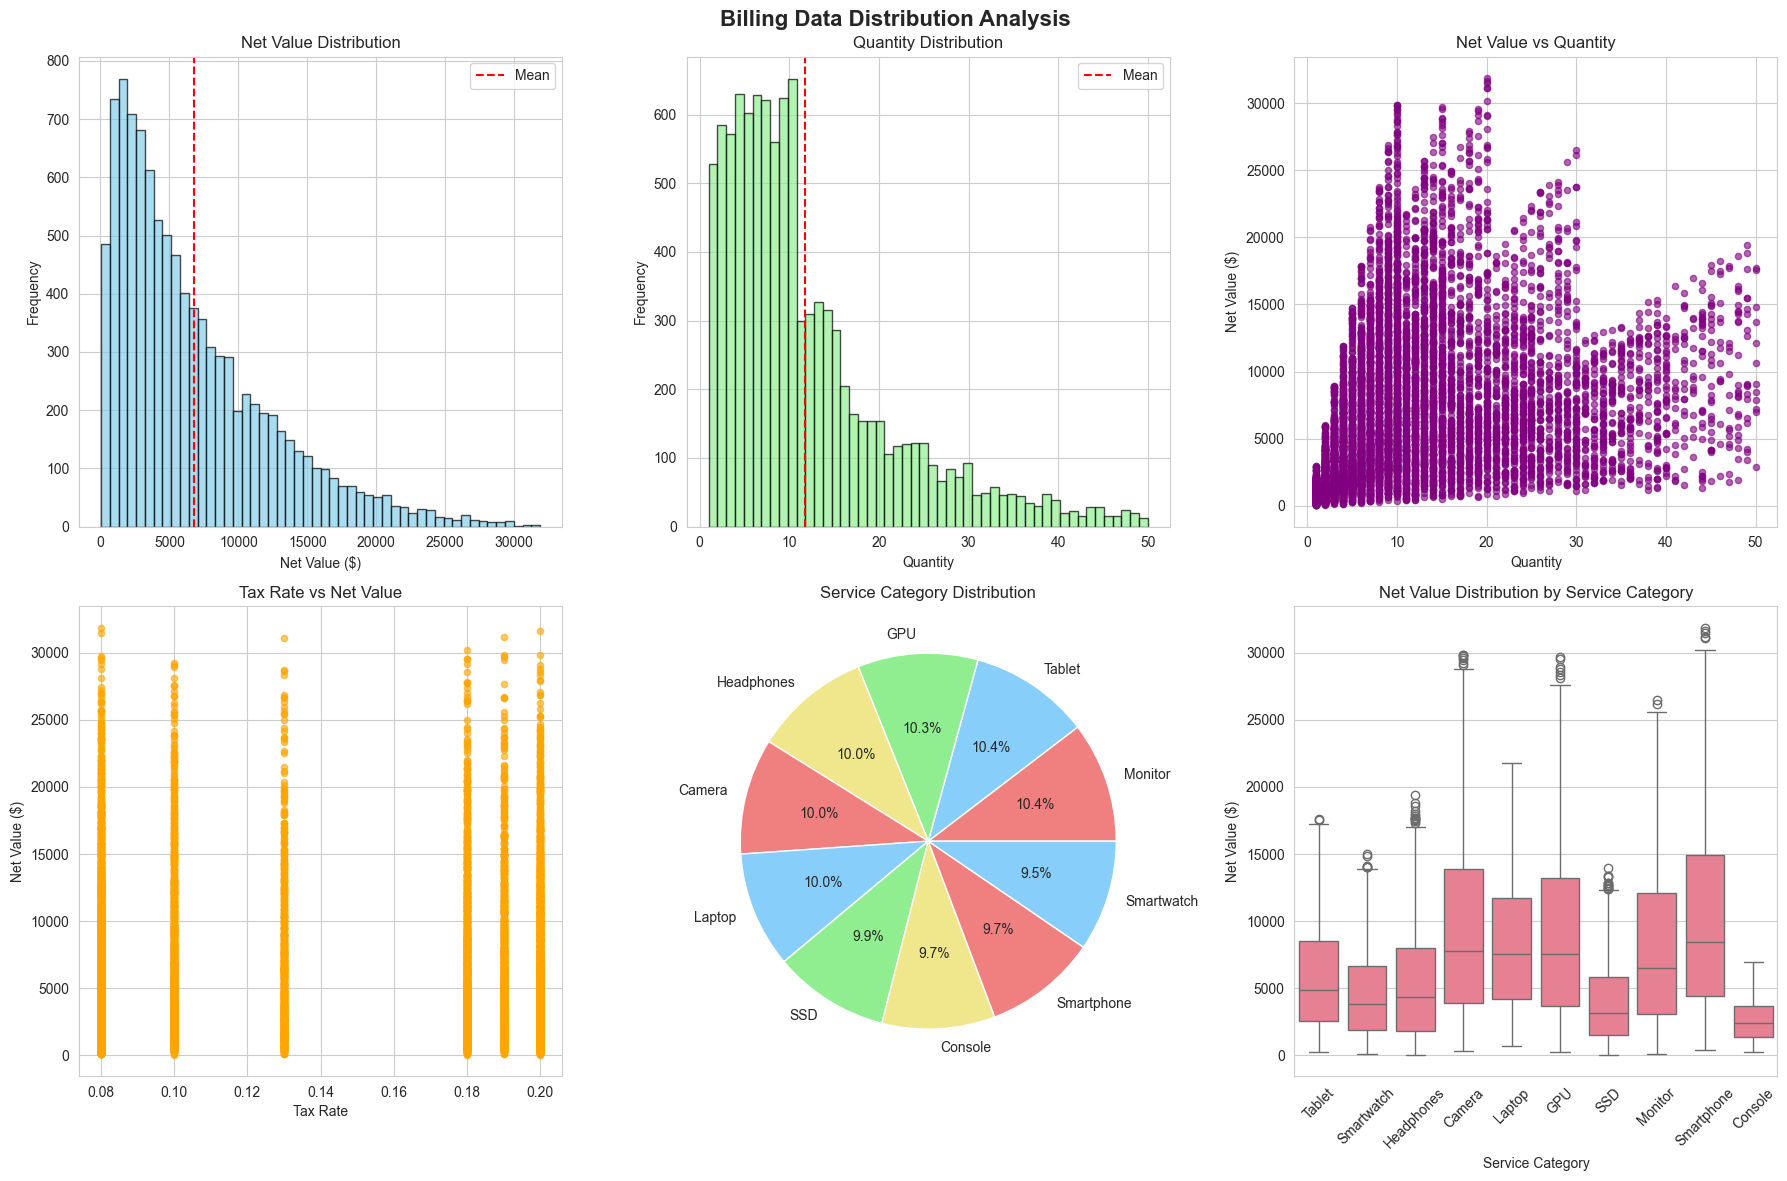

Statistical Summary:
          quantity    unit_price     net_value     tax_rate    tax_amount  \
count  10000.00000  10000.000000  10000.000000  10000.00000  10000.000000   
mean      11.77900    768.858025   6749.999615      0.14145    952.476179   
std        9.83138    617.397993   5647.267376      0.05120    913.578832   
min        1.00000     30.010000     41.570000      0.08000      5.550000   
25%        5.00000    302.020000   2398.545000      0.08000    301.175000   
50%        9.00000    569.375000   5108.040000      0.13000    655.460000   
75%       15.00000   1095.430000   9572.570000      0.19000   1298.797500   
max       50.00000   2993.130000  31881.000000      0.20000   6325.440000   

       total_amount  
count  10000.000000  
mean    7702.475794  
std     6458.169274  
min       49.880000  
25%     2737.320000  
50%     5808.015000  
75%    10952.200000  
max    37952.640000  


In [47]:
# Data exploration and visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Billing Data Distribution Analysis', fontsize=16, fontweight='bold')

# Determine correct column names based on what's available
amount_col = 'net_value' if 'net_value' in billing_data.columns else 'total_amount'
service_col = 'service_category' if 'service_category' in billing_data.columns else 'service_type'

# Amount distribution
axes[0, 0].hist(billing_data[amount_col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title(f'{amount_col.replace("_", " ").title()} Distribution')
axes[0, 0].set_xlabel(f'{amount_col.replace("_", " ").title()} ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(billing_data[amount_col].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Usage hours distribution (if available)
if 'usage_hours' in billing_data.columns:
    axes[0, 1].hist(billing_data['usage_hours'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Usage Hours Distribution')
    axes[0, 1].set_xlabel('Usage Hours')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(billing_data['usage_hours'].mean(), color='red', linestyle='--', label='Mean')
    axes[0, 1].legend()
else:
    # Use quantity as fallback
    quantity_col = 'quantity' if 'quantity' in billing_data.columns else 'unit_price'
    axes[0, 1].hist(billing_data[quantity_col], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title(f'{quantity_col.replace("_", " ").title()} Distribution')
    axes[0, 1].set_xlabel(quantity_col.replace("_", " ").title())
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(billing_data[quantity_col].mean(), color='red', linestyle='--', label='Mean')
    axes[0, 1].legend()

# Amount vs Usage scatter plot
if 'usage_hours' in billing_data.columns:
    scatter = axes[0, 2].scatter(billing_data['usage_hours'], billing_data[amount_col], 
                               alpha=0.6, c='purple', s=20)
    axes[0, 2].set_title(f'{amount_col.replace("_", " ").title()} vs Usage Hours')
    axes[0, 2].set_xlabel('Usage Hours')
    axes[0, 2].set_ylabel(f'{amount_col.replace("_", " ").title()} ($)')
else:
    # Use quantity vs amount
    quantity_col = 'quantity' if 'quantity' in billing_data.columns else 'unit_price'
    scatter = axes[0, 2].scatter(billing_data[quantity_col], billing_data[amount_col], 
                               alpha=0.6, c='purple', s=20)
    axes[0, 2].set_title(f'{amount_col.replace("_", " ").title()} vs {quantity_col.replace("_", " ").title()}')
    axes[0, 2].set_xlabel(quantity_col.replace("_", " ").title())
    axes[0, 2].set_ylabel(f'{amount_col.replace("_", " ").title()} ($)')

# Previous amount vs current amount (if available)
if 'previous_amount' in billing_data.columns:
    axes[1, 0].scatter(billing_data['previous_amount'], billing_data[amount_col], 
                      alpha=0.6, c='orange', s=20)
    axes[1, 0].set_title(f'Previous vs Current {amount_col.replace("_", " ").title()}')
    axes[1, 0].set_xlabel(f'Previous {amount_col.replace("_", " ").title()} ($)')
    axes[1, 0].set_ylabel(f'Current {amount_col.replace("_", " ").title()} ($)')
    axes[1, 0].plot([0, billing_data[amount_col].max()], [0, billing_data[amount_col].max()], 
                    'r--', alpha=0.8, label='y=x line')
    axes[1, 0].legend()
else:
    # Use tax_rate vs amount
    tax_col = 'tax_rate' if 'tax_rate' in billing_data.columns else 'unit_price'
    axes[1, 0].scatter(billing_data[tax_col], billing_data[amount_col], 
                      alpha=0.6, c='orange', s=20)
    axes[1, 0].set_title(f'{tax_col.replace("_", " ").title()} vs {amount_col.replace("_", " ").title()}')
    axes[1, 0].set_xlabel(tax_col.replace("_", " ").title())
    axes[1, 0].set_ylabel(f'{amount_col.replace("_", " ").title()} ($)')

# Service type distribution
if service_col in billing_data.columns:
    service_counts = billing_data[service_col].value_counts()
    axes[1, 1].pie(service_counts.values, labels=service_counts.index, autopct='%1.1f%%', 
                   colors=['lightcoral', 'lightskyblue', 'lightgreen', 'khaki'])
    axes[1, 1].set_title(f'{service_col.replace("_", " ").title()} Distribution')
else:
    # Use country distribution as fallback
    country_col = 'country' if 'country' in billing_data.columns else 'currency'
    country_counts = billing_data[country_col].value_counts()
    axes[1, 1].pie(country_counts.values, labels=country_counts.index, autopct='%1.1f%%', 
                   colors=['lightcoral', 'lightskyblue', 'lightgreen', 'khaki'])
    axes[1, 1].set_title(f'{country_col.replace("_", " ").title()} Distribution')

# Box plot for amounts by service type
if service_col in billing_data.columns:
    sns.boxplot(data=billing_data, x=service_col, y=amount_col, ax=axes[1, 2])
    axes[1, 2].set_title(f'{amount_col.replace("_", " ").title()} Distribution by {service_col.replace("_", " ").title()}')
    axes[1, 2].set_xlabel(service_col.replace("_", " ").title())
    axes[1, 2].set_ylabel(f'{amount_col.replace("_", " ").title()} ($)')
    axes[1, 2].tick_params(axis='x', rotation=45)
else:
    # Use country distribution as fallback
    country_col = 'country' if 'country' in billing_data.columns else 'currency'
    sns.boxplot(data=billing_data, x=country_col, y=amount_col, ax=axes[1, 2])
    axes[1, 2].set_title(f'{amount_col.replace("_", " ").title()} Distribution by {country_col.replace("_", " ").title()}')
    axes[1, 2].set_xlabel(country_col.replace("_", " ").title())
    axes[1, 2].set_ylabel(f'{amount_col.replace("_", " ").title()} ($)')
    axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical summary
print("Statistical Summary:")
print(billing_data.describe())

In [48]:
# Feature engineering
# Create additional features that might help detect anomalies

# Determine correct column names
amount_col = 'net_value' if 'net_value' in billing_data.columns else 'total_amount'
service_col = 'service_category' if 'service_category' in billing_data.columns else 'service_type'

# Create derived features based on available columns
if 'usage_hours' in billing_data.columns:
    billing_data['amount_per_hour'] = billing_data[amount_col] / (billing_data['usage_hours'] + 1)  # +1 to avoid division by zero

if 'previous_amount' in billing_data.columns:
    billing_data['amount_change_ratio'] = billing_data[amount_col] / (billing_data['previous_amount'] + 1)

if 'account_age_days' in billing_data.columns and 'usage_hours' in billing_data.columns:
    billing_data['usage_intensity'] = billing_data['usage_hours'] / (billing_data['account_age_days'] + 1)

# Select numerical features for anomaly detection based on what's available
numerical_features = []

# Core financial features
if amount_col in billing_data.columns:
    numerical_features.append(amount_col)
if 'unit_price' in billing_data.columns:
    numerical_features.append('unit_price')
if 'quantity' in billing_data.columns:
    numerical_features.append('quantity')
if 'tax_rate' in billing_data.columns:
    numerical_features.append('tax_rate')
if 'tax_amount' in billing_data.columns:
    numerical_features.append('tax_amount')

# Usage-related features
if 'usage_hours' in billing_data.columns:
    numerical_features.append('usage_hours')
if 'previous_amount' in billing_data.columns:
    numerical_features.append('previous_amount')
if 'account_age_days' in billing_data.columns:
    numerical_features.append('account_age_days')

# Derived features
if 'amount_per_hour' in billing_data.columns:
    numerical_features.append('amount_per_hour')
if 'amount_change_ratio' in billing_data.columns:
    numerical_features.append('amount_change_ratio')
if 'usage_intensity' in billing_data.columns:
    numerical_features.append('usage_intensity')

# Ensure we have at least some features
if len(numerical_features) == 0:
    # Fallback to any numerical columns
    numerical_features = billing_data.select_dtypes(include=[np.number]).columns.tolist()

print(f"Available numerical features: {numerical_features}")

# Prepare data for algorithms
X = billing_data[numerical_features].copy()

# Handle any missing values
X = X.fillna(X.median())

# Remove any infinite values
X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

print("Feature Matrix Shape:", X.shape)
print("\nFeatures used for anomaly detection:")
for i, feature in enumerate(numerical_features, 1):
    print(f"{i}. {feature}")

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_features)

print("\nFeatures standardized for algorithm input")
print("Standardized data shape:", X_scaled.shape)

Available numerical features: ['net_value', 'unit_price', 'quantity', 'tax_rate', 'tax_amount']
Feature Matrix Shape: (10000, 5)

Features used for anomaly detection:
1. net_value
2. unit_price
3. quantity
4. tax_rate
5. tax_amount

Features standardized for algorithm input
Standardized data shape: (10000, 5)


# Isolation Forest Algorithm Visualization

Isolation Forest detects anomalies by isolating observations through random splits. Let's visualize how this algorithm works step by step.

🌳 ISOLATION FOREST ALGORITHM WALKTHROUGH
Concept: Anomalies are easier to isolate (require fewer splits) than normal points
The algorithm creates random splits and measures the path length to isolate each point



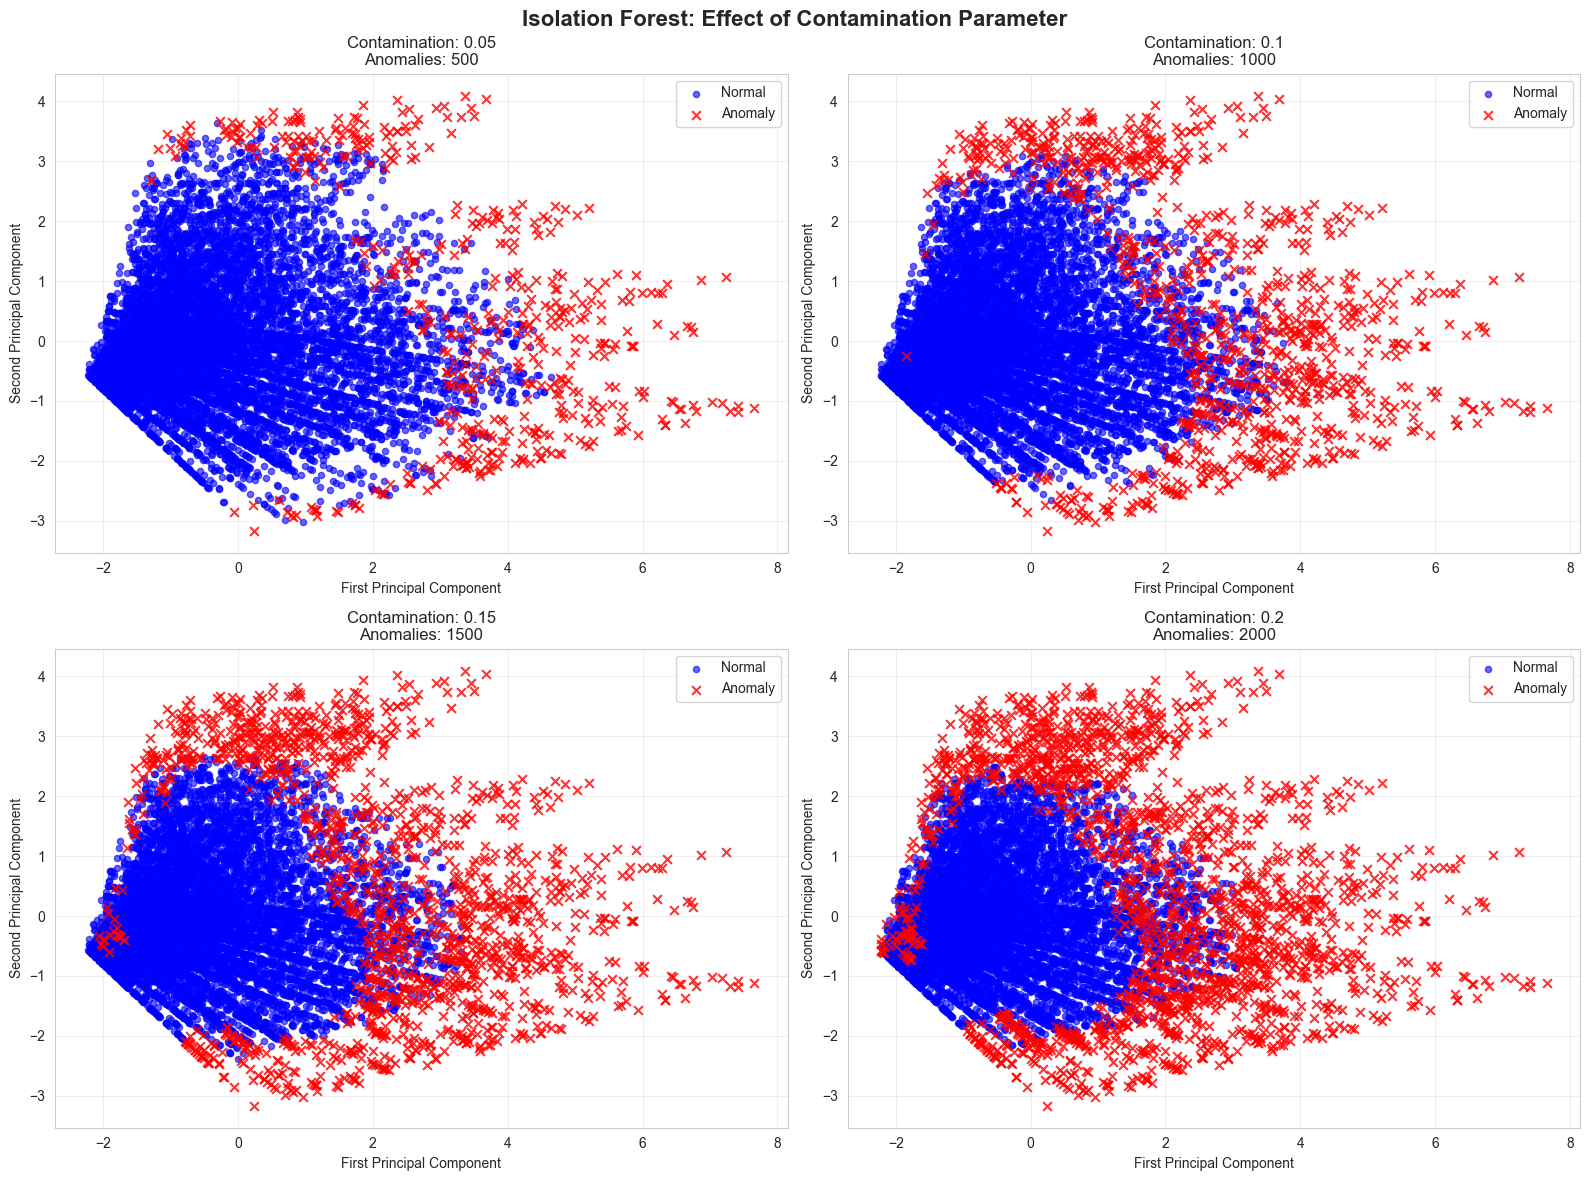


Isolation Forest Results Summary:
----------------------------------------
Contamination 0.05: 500 anomalies detected
Contamination 0.10: 1000 anomalies detected
Contamination 0.15: 1500 anomalies detected
Contamination 0.20: 2000 anomalies detected


In [49]:
# Step 1: Understanding Isolation Forest Concept
print("🌳 ISOLATION FOREST ALGORITHM WALKTHROUGH")
print("="*50)
print("Concept: Anomalies are easier to isolate (require fewer splits) than normal points")
print("The algorithm creates random splits and measures the path length to isolate each point")
print()

# Apply Isolation Forest with different contamination levels
contamination_levels = [0.05, 0.1, 0.15, 0.2]
isolation_results = {}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Isolation Forest: Effect of Contamination Parameter', fontsize=16, fontweight='bold')

# Use PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_features = ['PC1', 'PC2']

for i, contamination in enumerate(contamination_levels):
    # Fit Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=42, n_estimators=100)
    predictions = iso_forest.fit_predict(X_scaled)
    scores = iso_forest.decision_function(X_scaled)
    
    # Store results
    isolation_results[contamination] = {
        'predictions': predictions,
        'scores': scores,
        'n_anomalies': sum(predictions == -1)
    }
    
    # Plot results
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    # Scatter plot with anomalies highlighted
    normal_mask = predictions == 1
    anomaly_mask = predictions == -1
    
    ax.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], 
              c='blue', alpha=0.6, s=20, label='Normal')
    ax.scatter(X_pca[anomaly_mask, 0], X_pca[anomaly_mask, 1], 
              c='red', alpha=0.8, s=40, label='Anomaly', marker='x')
    
    ax.set_title(f'Contamination: {contamination}\nAnomalies: {sum(predictions == -1)}')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display results summary
print("\nIsolation Forest Results Summary:")
print("-" * 40)
for cont, results in isolation_results.items():
    print(f"Contamination {cont:4.2f}: {results['n_anomalies']:3d} anomalies detected")

🔍 ISOLATION FOREST DECISION ANALYSIS


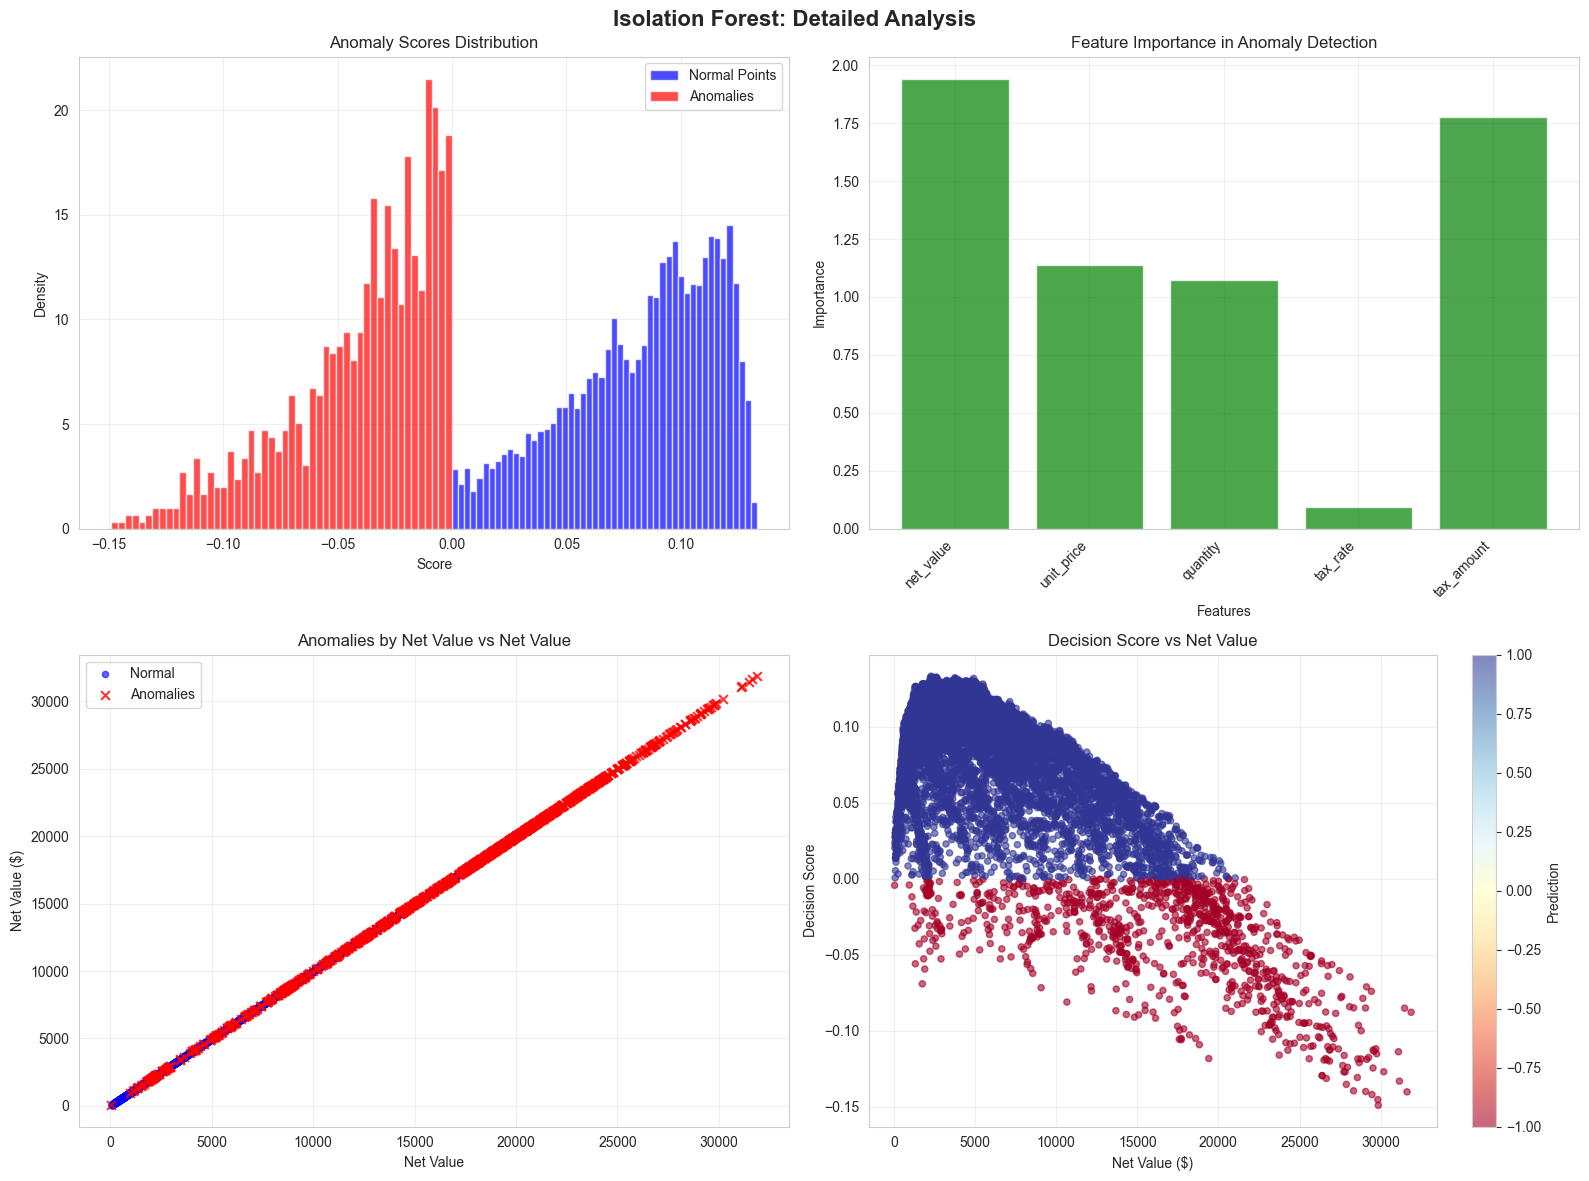

Isolation Forest Results (contamination=0.1):
Total samples: 10000
Normal points: 9000 (90.0%)
Anomalies: 1000 (10.0%)
Average decision score (normal): 0.082
Average decision score (anomalies): -0.040


In [50]:
# Step 2: Detailed Analysis of Isolation Forest Decision Process
print("🔍 ISOLATION FOREST DECISION ANALYSIS")
print("="*50)

# Use optimal contamination (let's use 0.1 for detailed analysis)
optimal_contamination = 0.1
iso_forest_final = IsolationForest(contamination=optimal_contamination, random_state=42, n_estimators=100)
final_predictions = iso_forest_final.fit_predict(X_scaled)
final_scores = iso_forest_final.decision_function(X_scaled)

# Matplotlib visualization (no plotly dependency)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Isolation Forest: Detailed Analysis', fontsize=16, fontweight='bold')

# 1. Anomaly scores distribution
axes[0, 0].hist(final_scores[final_predictions == 1], bins=50, alpha=0.7, 
               color='blue', label='Normal Points', density=True)
axes[0, 0].hist(final_scores[final_predictions == -1], bins=50, alpha=0.7, 
               color='red', label='Anomalies', density=True)
axes[0, 0].set_title('Anomaly Scores Distribution')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Feature importance
feature_importance = np.abs(X_scaled[final_predictions == -1].mean(axis=0) - 
                           X_scaled[final_predictions == 1].mean(axis=0))
axes[0, 1].bar(range(len(numerical_features)), feature_importance, color='green', alpha=0.7)
axes[0, 1].set_title('Feature Importance in Anomaly Detection')
axes[0, 1].set_xlabel('Features')
axes[0, 1].set_ylabel('Importance')
axes[0, 1].set_xticks(range(len(numerical_features)))
axes[0, 1].set_xticklabels(numerical_features, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

# 3. Anomalies in original feature space
# Use the first available feature for x-axis and amount column for y-axis
x_feature = 'usage_hours' if 'usage_hours' in billing_data.columns else numerical_features[0]
y_feature = amount_col

axes[1, 0].scatter(billing_data[final_predictions == 1][x_feature],
                  billing_data[final_predictions == 1][y_feature],
                  c='blue', alpha=0.6, s=20, label='Normal')
axes[1, 0].scatter(billing_data[final_predictions == -1][x_feature],
                  billing_data[final_predictions == -1][y_feature],
                  c='red', alpha=0.8, s=40, marker='x', label='Anomalies')
axes[1, 0].set_title(f'Anomalies by {y_feature.replace("_", " ").title()} vs {x_feature.replace("_", " ").title()}')
axes[1, 0].set_xlabel(x_feature.replace("_", " ").title())
axes[1, 0].set_ylabel(f'{y_feature.replace("_", " ").title()} ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Decision scores vs amount
scatter = axes[1, 1].scatter(billing_data[y_feature], final_scores,
                            c=final_predictions, cmap='RdYlBu', alpha=0.6, s=20)
axes[1, 1].set_title(f'Decision Score vs {y_feature.replace("_", " ").title()}')
axes[1, 1].set_xlabel(f'{y_feature.replace("_", " ").title()} ($)')
axes[1, 1].set_ylabel('Decision Score')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='Prediction')

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"Isolation Forest Results (contamination={optimal_contamination}):")
print(f"Total samples: {len(final_predictions)}")
print(f"Normal points: {sum(final_predictions == 1)} ({sum(final_predictions == 1)/len(final_predictions)*100:.1f}%)")
print(f"Anomalies: {sum(final_predictions == -1)} ({sum(final_predictions == -1)/len(final_predictions)*100:.1f}%)")
print(f"Average decision score (normal): {final_scores[final_predictions == 1].mean():.3f}")
print(f"Average decision score (anomalies): {final_scores[final_predictions == -1].mean():.3f}")

# DBSCAN Algorithm Visualization

DBSCAN (Density-Based Spatial Clustering) identifies anomalies as points that don't belong to any dense cluster. Let's explore how this algorithm works.

In [51]:
# Step 1: Understanding DBSCAN Parameters
print("🔍 DBSCAN ALGORITHM WALKTHROUGH")
print("="*50)
print("Concept: Points in sparse regions are considered anomalies")
print("Key parameters: eps (neighborhood radius) and min_samples (minimum points in neighborhood)")
print()

# Test different DBSCAN parameters
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [5, 10, 15, 20]

# Find optimal parameters using silhouette score
best_score = -1
best_params = {}
param_results = {}

print("Testing DBSCAN parameters...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        # Calculate number of clusters and noise points
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Calculate silhouette score (only if we have clusters)
        if n_clusters > 1 and n_noise < len(labels) - 1:
            try:
                sil_score = silhouette_score(X_scaled, labels)
                if sil_score > best_score:
                    best_score = sil_score
                    best_params = {'eps': eps, 'min_samples': min_samples}
            except:
                sil_score = -1
        else:
            sil_score = -1
            
        param_results[(eps, min_samples)] = {
            'labels': labels,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil_score
        }

print(f"Best parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"Best silhouette score: {best_score:.3f}")

🔍 DBSCAN ALGORITHM WALKTHROUGH
Concept: Points in sparse regions are considered anomalies
Key parameters: eps (neighborhood radius) and min_samples (minimum points in neighborhood)

Testing DBSCAN parameters...
Best parameters: eps=0.7, min_samples=20
Best silhouette score: 0.252
Best parameters: eps=0.7, min_samples=20
Best silhouette score: 0.252


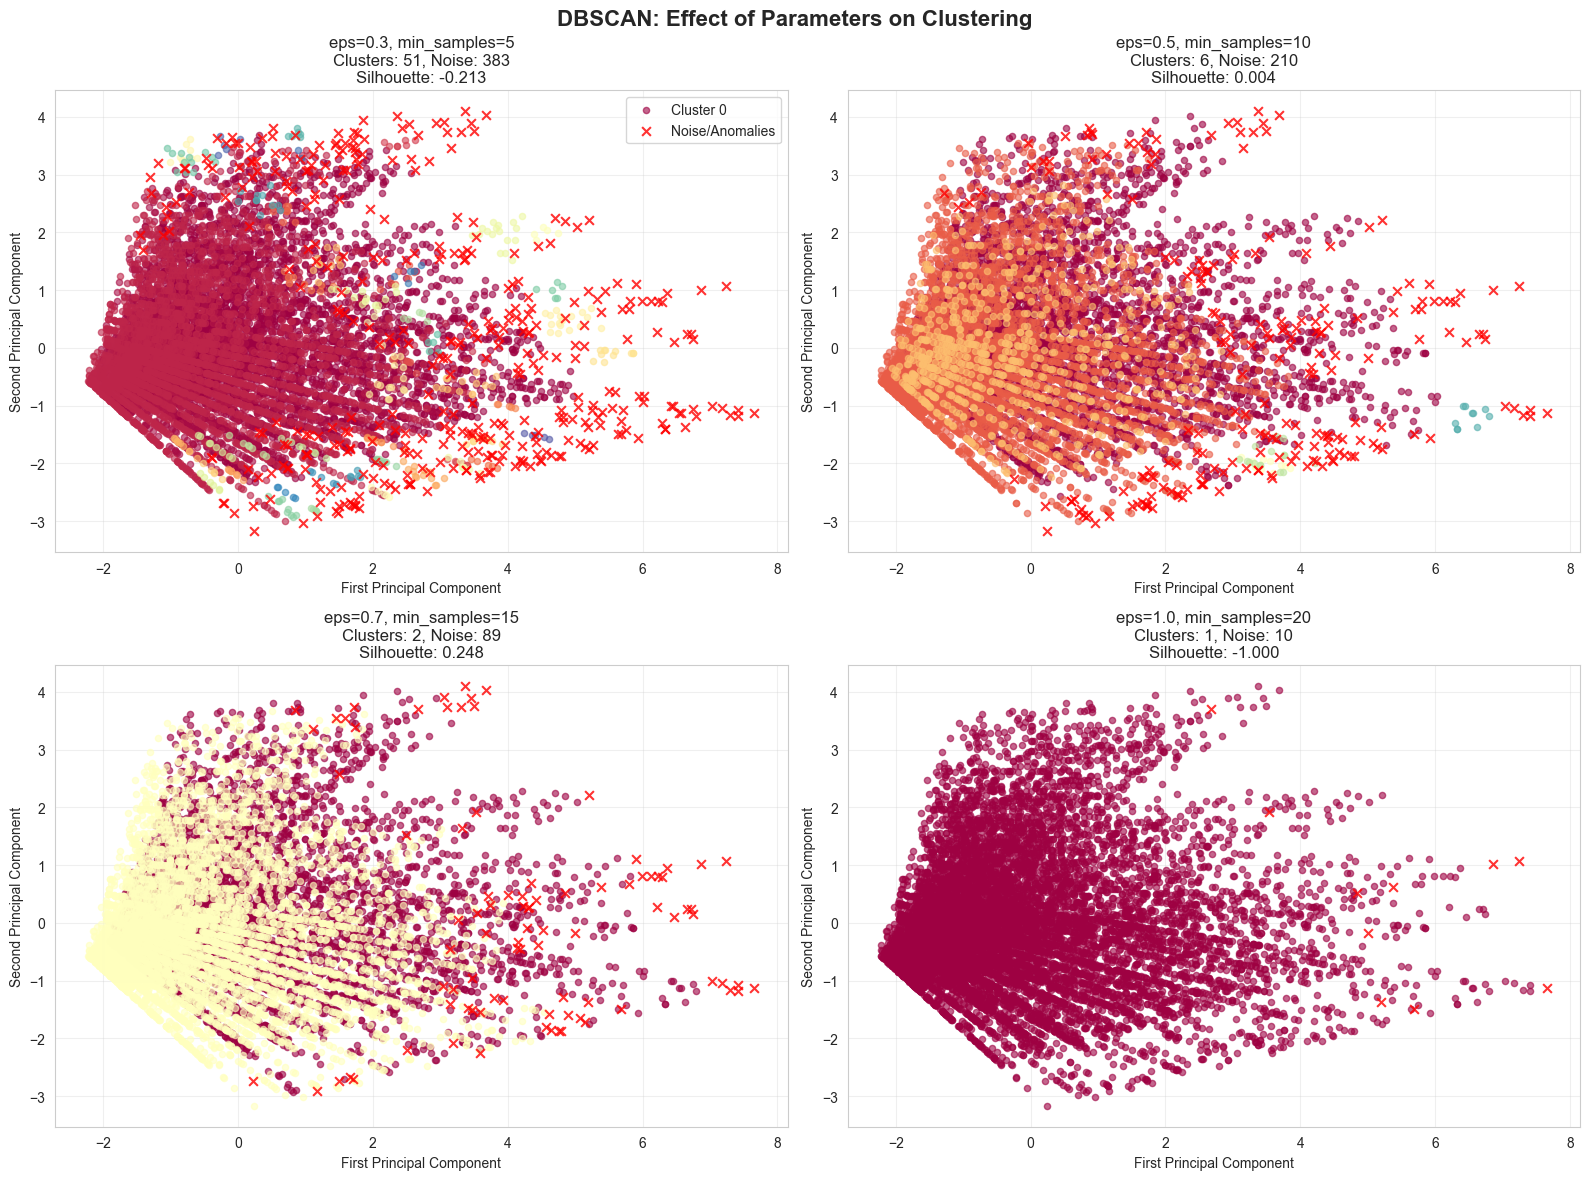


DBSCAN Parameter Testing Results:
------------------------------------------------------------
  eps  min_samples  clusters   noise  silhouette
------------------------------------------------------------
  0.3            5        51     383      -0.213
  0.3           10        14    1119      -0.172
  0.3           15        14    1728      -0.243
  0.3           20        11    2314      -0.202
  0.5            5         9      44      -0.037
  0.5           10         6     210       0.004
  0.5           15         4     437       0.002
  0.5           20         3     632       0.017
  0.7            5         3       6       0.229
  0.7           10         2      37       0.242
  0.7           15         2      89       0.248
  0.7           20         2     130       0.252
  1.0            5         1       1      -1.000
  1.0           10         1       3      -1.000
  1.0           15         1       5      -1.000
  1.0           20         1      10      -1.000


In [52]:
# Step 2: Visualize DBSCAN with different parameters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DBSCAN: Effect of Parameters on Clustering', fontsize=16, fontweight='bold')

# Select 4 representative parameter combinations for visualization
selected_params = [(0.3, 5), (0.5, 10), (0.7, 15), (1.0, 20)]

for i, (eps, min_samples) in enumerate(selected_params):
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    # Get results for these parameters
    labels = param_results[(eps, min_samples)]['labels']
    n_clusters = param_results[(eps, min_samples)]['n_clusters']
    n_noise = param_results[(eps, min_samples)]['n_noise']
    sil_score = param_results[(eps, min_samples)]['silhouette']
    
    # Create scatter plot
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise (anomalies)
            col = 'red'
            marker = 'x'
            size = 40
            alpha = 0.8
            label = 'Noise/Anomalies'
        else:
            marker = 'o'
            size = 20
            alpha = 0.6
            label = f'Cluster {k}'
        
        class_member_mask = (labels == k)
        xy = X_pca[class_member_mask]
        ax.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=size, alpha=alpha, 
                  label=label if k == -1 or k == 0 else "")
    
    ax.set_title(f'eps={eps}, min_samples={min_samples}\n'
                f'Clusters: {n_clusters}, Noise: {n_noise}\n'
                f'Silhouette: {sil_score:.3f}')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    if i == 0:  # Only show legend for first subplot to avoid clutter
        ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display parameter testing results
print("\nDBSCAN Parameter Testing Results:")
print("-" * 60)
print(f"{'eps':>5} {'min_samples':>12} {'clusters':>9} {'noise':>7} {'silhouette':>11}")
print("-" * 60)
for (eps, min_samples), results in param_results.items():
    print(f"{eps:>5.1f} {min_samples:>12} {results['n_clusters']:>9} "
          f"{results['n_noise']:>7} {results['silhouette']:>11.3f}")

🔍 DBSCAN DETAILED ANALYSIS
Final DBSCAN Results:
Parameters used: eps=0.7, min_samples=20
Number of clusters: 2
Number of anomalies (noise): 130
Cluster sizes: [4852, 5018]


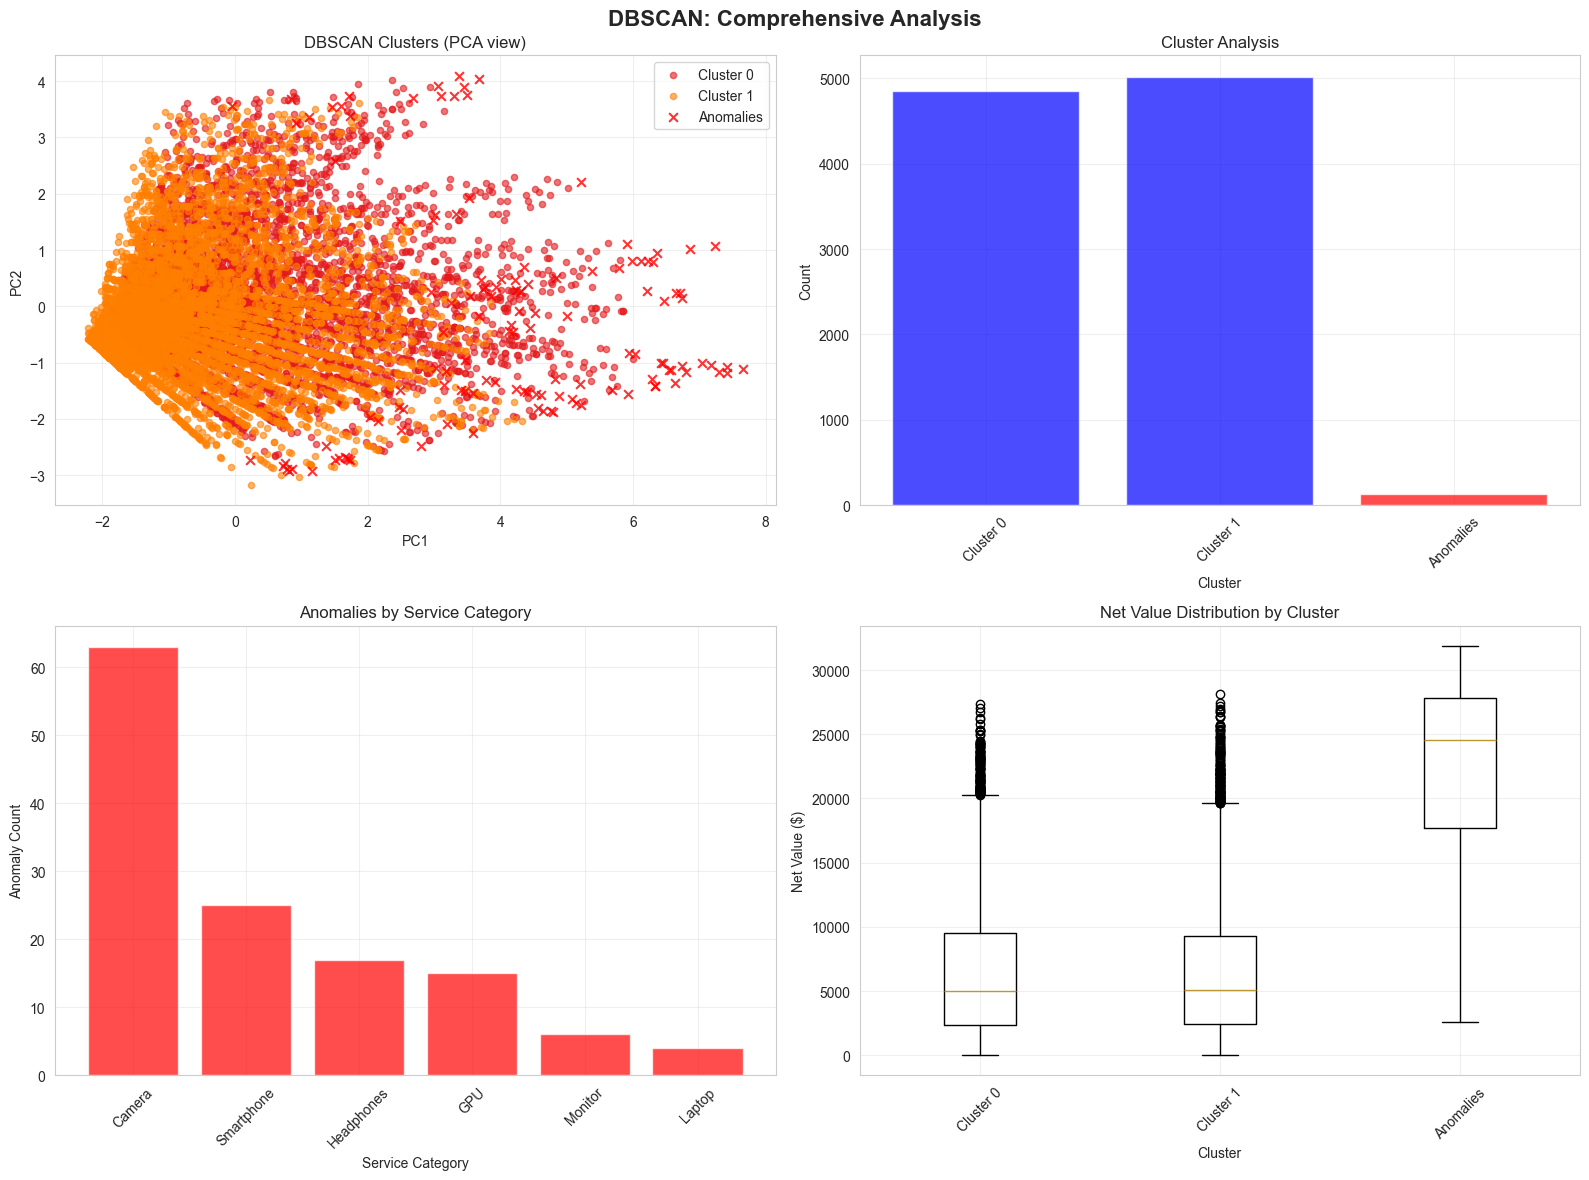


Cluster Statistics:
--------------------------------------------------
ANOMALIES (n=130):
  Net Value: $21676.03 ± $7920.82
  Service types: {'Camera': 63, 'Smartphone': 25, 'Headphones': 17, 'GPU': 15, 'Monitor': 6, 'Laptop': 4}

CLUSTER 0 (n=4852):
  Net Value: $6555.07 ± $5347.03
  Service types: {'SSD': 507, 'Tablet': 502, 'Smartwatch': 499, 'Monitor': 495, 'GPU': 490, 'Headphones': 486, 'Laptop': 484, 'Smartphone': 480, 'Camera': 459, 'Console': 450}

CLUSTER 1 (n=5018):
  Net Value: $6551.79 ± $5334.23
  Service types: {'Monitor': 537, 'Tablet': 534, 'GPU': 529, 'Console': 522, 'Laptop': 510, 'Headphones': 501, 'SSD': 488, 'Camera': 476, 'Smartphone': 466, 'Smartwatch': 455}



In [53]:
# Step 3: Detailed Analysis of DBSCAN Results
print("🔍 DBSCAN DETAILED ANALYSIS")
print("="*50)

# Use best parameters for detailed analysis
best_eps = best_params['eps']
best_min_samples = best_params['min_samples']

dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan_final.fit_predict(X_scaled)

# Analyze results
n_clusters_final = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_final = list(dbscan_labels).count(-1)
cluster_sizes = [list(dbscan_labels).count(i) for i in range(n_clusters_final)]

print(f"Final DBSCAN Results:")
print(f"Parameters used: eps={best_eps}, min_samples={best_min_samples}")
print(f"Number of clusters: {n_clusters_final}")
print(f"Number of anomalies (noise): {n_noise_final}")
print(f"Cluster sizes: {cluster_sizes}")

# Matplotlib fallback visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DBSCAN: Comprehensive Analysis', fontsize=16, fontweight='bold')

# 1. Cluster visualization in PCA space
unique_labels = set(dbscan_labels)
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

for i, k in enumerate(unique_labels):
    if k == -1:
        color = 'red'
        marker = 'x'
        size = 40
        alpha = 0.8
        label = 'Anomalies'
    else:
        color = colors[i % len(colors)]
        marker = 'o'
        size = 20
        alpha = 0.6
        label = f'Cluster {k}'
    
    mask = dbscan_labels == k
    axes[0, 0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                      c=[color], marker=marker, s=size, alpha=alpha, label=label)

axes[0, 0].set_title('DBSCAN Clusters (PCA view)')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Cluster size analysis
cluster_labels = [f'Cluster {i}' for i in range(n_clusters_final)] + ['Anomalies']
cluster_counts = cluster_sizes + [n_noise_final]
colors_bar = ['blue'] * n_clusters_final + ['red']
axes[0, 1].bar(cluster_labels, cluster_counts, color=colors_bar, alpha=0.7)
axes[0, 1].set_title('Cluster Analysis')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Anomalies by service type
if n_noise_final > 0 and service_col in billing_data.columns:
    anomaly_mask = dbscan_labels == -1
    anomaly_services = billing_data[anomaly_mask][service_col].value_counts()
    axes[1, 0].bar(anomaly_services.index, anomaly_services.values, 
                  color='red', alpha=0.7)
    axes[1, 0].set_title(f'Anomalies by {service_col.replace("_", " ").title()}')
    axes[1, 0].set_xlabel(service_col.replace("_", " ").title())
    axes[1, 0].set_ylabel('Anomaly Count')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No anomalies detected\nor service column not available', 
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Anomalies by Service Type')

# 4. Amount distribution by cluster
cluster_data = []
cluster_names = []
for k in unique_labels:
    mask = dbscan_labels == k
    amounts = billing_data[mask][amount_col]
    if len(amounts) > 0:
        cluster_data.append(amounts)
        if k == -1:
            cluster_names.append('Anomalies')
        else:
            cluster_names.append(f'Cluster {k}')

if cluster_data:
    axes[1, 1].boxplot(cluster_data, labels=cluster_names)
    axes[1, 1].set_title(f'{amount_col.replace("_", " ").title()} Distribution by Cluster')
    axes[1, 1].set_xlabel('Cluster')
    axes[1, 1].set_ylabel(f'{amount_col.replace("_", " ").title()} ($)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed statistics for each cluster
print(f"\nCluster Statistics:")
print("-" * 50)
for k in sorted(unique_labels):
    mask = dbscan_labels == k
    cluster_data = billing_data[mask]
    
    if k == -1:
        print(f"ANOMALIES (n={sum(mask)}):")
    else:
        print(f"CLUSTER {k} (n={sum(mask)}):")
    
    if sum(mask) > 0:
        print(f"  {amount_col.replace('_', ' ').title()}: ${cluster_data[amount_col].mean():.2f} ± ${cluster_data[amount_col].std():.2f}")
        if 'usage_hours' in cluster_data.columns:
            print(f"  Usage: {cluster_data['usage_hours'].mean():.1f} ± {cluster_data['usage_hours'].std():.1f} hours")
        if service_col in cluster_data.columns:
            print(f"  Service types: {cluster_data[service_col].value_counts().to_dict()}")
    print()

🔄 ALGORITHM COMPARISON
Comparison Results:
Isolation Forest anomalies: 1000
DBSCAN anomalies: 130
Overlap (both detect): 130
Isolation Forest only: 870
DBSCAN only: 0
Agreement rate: 91.3%


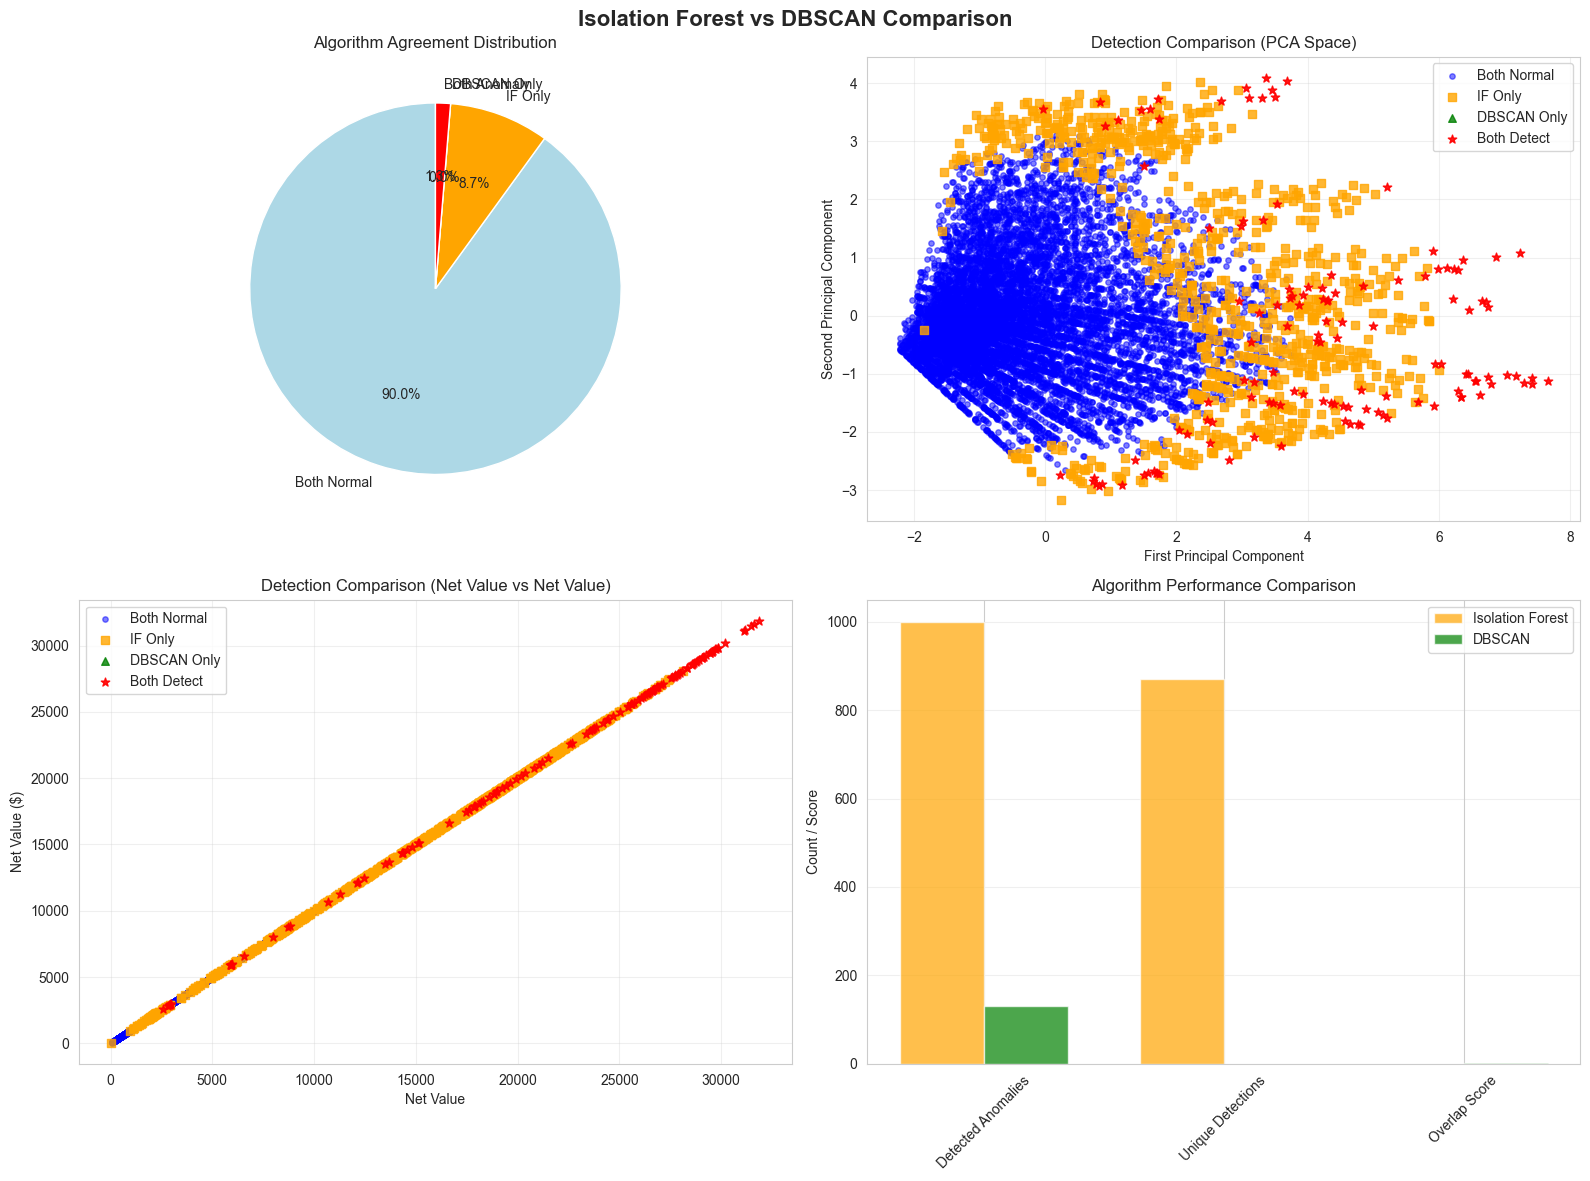

In [54]:
# Compare Isolation Forest vs DBSCAN results
print("🔄 ALGORITHM COMPARISON")
print("="*50)

# Get final results from both algorithms
iso_anomalies = final_predictions == -1
dbscan_anomalies = dbscan_labels == -1

# Calculate overlap and differences
overlap = iso_anomalies & dbscan_anomalies
iso_only = iso_anomalies & ~dbscan_anomalies
dbscan_only = dbscan_anomalies & ~iso_anomalies
both_normal = ~iso_anomalies & ~dbscan_anomalies

print(f"Comparison Results:")
print(f"Isolation Forest anomalies: {sum(iso_anomalies)}")
print(f"DBSCAN anomalies: {sum(dbscan_anomalies)}")
print(f"Overlap (both detect): {sum(overlap)}")
print(f"Isolation Forest only: {sum(iso_only)}")
print(f"DBSCAN only: {sum(dbscan_only)}")
print(f"Agreement rate: {(sum(overlap) + sum(both_normal)) / len(billing_data) * 100:.1f}%")

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Isolation Forest vs DBSCAN Comparison', fontsize=16, fontweight='bold')

# 1. Venn diagram-style visualization
categories = ['Both Normal', 'IF Only', 'DBSCAN Only', 'Both Anomaly']
counts = [sum(both_normal), sum(iso_only), sum(dbscan_only), sum(overlap)]
colors = ['lightblue', 'orange', 'lightgreen', 'red']

axes[0, 0].pie(counts, labels=categories, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 0].set_title('Algorithm Agreement Distribution')

# 2. Scatter plot showing different detections
axes[0, 1].scatter(X_pca[both_normal, 0], X_pca[both_normal, 1], 
                  c='blue', alpha=0.5, s=15, label='Both Normal')
axes[0, 1].scatter(X_pca[iso_only, 0], X_pca[iso_only, 1], 
                  c='orange', alpha=0.8, s=30, marker='s', label='IF Only')
axes[0, 1].scatter(X_pca[dbscan_only, 0], X_pca[dbscan_only, 1], 
                  c='green', alpha=0.8, s=30, marker='^', label='DBSCAN Only')
axes[0, 1].scatter(X_pca[overlap, 0], X_pca[overlap, 1], 
                  c='red', alpha=0.9, s=40, marker='*', label='Both Detect')
axes[0, 1].set_title('Detection Comparison (PCA Space)')
axes[0, 1].set_xlabel('First Principal Component')
axes[0, 1].set_ylabel('Second Principal Component')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Amount vs Usage with different detections
x_feature = 'usage_hours' if 'usage_hours' in billing_data.columns else numerical_features[0]
y_feature = amount_col

axes[1, 0].scatter(billing_data[both_normal][x_feature], 
                  billing_data[both_normal][y_feature],
                  c='blue', alpha=0.5, s=15, label='Both Normal')
axes[1, 0].scatter(billing_data[iso_only][x_feature], 
                  billing_data[iso_only][y_feature],
                  c='orange', alpha=0.8, s=30, marker='s', label='IF Only')
axes[1, 0].scatter(billing_data[dbscan_only][x_feature], 
                  billing_data[dbscan_only][y_feature],
                  c='green', alpha=0.8, s=30, marker='^', label='DBSCAN Only')
axes[1, 0].scatter(billing_data[overlap][x_feature], 
                  billing_data[overlap][y_feature],
                  c='red', alpha=0.9, s=40, marker='*', label='Both Detect')
axes[1, 0].set_title(f'Detection Comparison ({y_feature.replace("_", " ").title()} vs {x_feature.replace("_", " ").title()})')
axes[1, 0].set_xlabel(x_feature.replace("_", " ").title())
axes[1, 0].set_ylabel(f'{y_feature.replace("_", " ").title()} ($)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Algorithm performance metrics
metrics = ['Detected Anomalies', 'Unique Detections', 'Overlap Score']
if_metrics = [sum(iso_anomalies), sum(iso_only), sum(overlap)/max(sum(iso_anomalies), 1)]
dbscan_metrics = [sum(dbscan_anomalies), sum(dbscan_only), sum(overlap)/max(sum(dbscan_anomalies), 1)]

x = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x - width/2, if_metrics, width, label='Isolation Forest', color='orange', alpha=0.7)
axes[1, 1].bar(x + width/2, dbscan_metrics, width, label='DBSCAN', color='green', alpha=0.7)
axes[1, 1].set_title('Algorithm Performance Comparison')
axes[1, 1].set_ylabel('Count / Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics, rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [55]:
# Detailed analysis of different anomaly types
print("🔍 ANOMALY TYPE ANALYSIS")
print("="*50)

# Analyze characteristics of different anomaly groups
groups = {
    'Both Algorithms': overlap,
    'Isolation Forest Only': iso_only,
    'DBSCAN Only': dbscan_only
}

analysis_results = {}
amount_col = 'net_value' if 'net_value' in billing_data.columns else 'total_amount'
service_col = 'service_category' if 'service_category' in billing_data.columns else 'service_type'

for group_name, mask in groups.items():
    if sum(mask) > 0:
        group_data = billing_data[mask]
        analysis_results[group_name] = {
            'count': sum(mask),
            'avg_amount': group_data[amount_col].mean(),
            'service_distribution': group_data[service_col].value_counts().to_dict() if service_col in group_data.columns else {}
        }
        
        # Add usage stats if available
        if 'usage_hours' in group_data.columns:
            analysis_results[group_name]['avg_usage'] = group_data['usage_hours'].mean()
        if 'amount_per_hour' in group_data.columns:
            analysis_results[group_name]['avg_amount_per_hour'] = group_data['amount_per_hour'].mean()
        
        print(f"{group_name.upper()} ({sum(mask)} anomalies):")
        print(f"  Average {amount_col.replace('_', ' ').title()}: ${analysis_results[group_name]['avg_amount']:.2f}")
        
        if 'avg_usage' in analysis_results[group_name]:
            print(f"  Average Usage: {analysis_results[group_name]['avg_usage']:.1f} hours")
        if 'avg_amount_per_hour' in analysis_results[group_name]:
            print(f"  Average Cost/Hour: ${analysis_results[group_name]['avg_amount_per_hour']:.2f}")
        
        if analysis_results[group_name]['service_distribution']:
            print(f"  Service Types: {analysis_results[group_name]['service_distribution']}")
        print()

# Create summary table
summary_df = pd.DataFrame({
    'Metric': ['Total Samples', 'IF Anomalies', 'DBSCAN Anomalies', 
               'Overlap', 'IF Only', 'DBSCAN Only', 'Agreement Rate (%)'],
    'Value': [len(billing_data), sum(iso_anomalies), sum(dbscan_anomalies),
              sum(overlap), sum(iso_only), sum(dbscan_only),
              f"{(sum(overlap) + sum(both_normal)) / len(billing_data) * 100:.1f}"]
})

print("SUMMARY TABLE:")
print("="*30)
print(summary_df.to_string(index=False))

🔍 ANOMALY TYPE ANALYSIS
BOTH ALGORITHMS (130 anomalies):
  Average Net Value: $21676.03
  Service Types: {'Camera': 63, 'Smartphone': 25, 'Headphones': 17, 'GPU': 15, 'Monitor': 6, 'Laptop': 4}

ISOLATION FOREST ONLY (870 anomalies):
  Average Net Value: $15855.06
  Service Types: {'Camera': 222, 'Headphones': 210, 'Smartphone': 119, 'Monitor': 117, 'GPU': 103, 'Laptop': 54, 'SSD': 45}

SUMMARY TABLE:
            Metric Value
     Total Samples 10000
      IF Anomalies  1000
  DBSCAN Anomalies   130
           Overlap   130
           IF Only   870
       DBSCAN Only     0
Agreement Rate (%)  91.3


In [56]:
# Save results for further analysis
results_summary = {
    'isolation_forest': {
        'contamination': optimal_contamination,
        'anomalies_detected': sum(iso_anomalies),
        'anomaly_indices': np.where(iso_anomalies)[0].tolist(),
        'decision_scores': final_scores.tolist()
    },
    'dbscan': {
        'eps': best_eps,
        'min_samples': best_min_samples,
        'anomalies_detected': sum(dbscan_anomalies),
        'anomaly_indices': np.where(dbscan_anomalies)[0].tolist(),
        'cluster_labels': dbscan_labels.tolist()
    },
    'comparison': {
        'overlap_count': sum(overlap),
        'agreement_rate': (sum(overlap) + sum(both_normal)) / len(billing_data),
        'iso_only_count': sum(iso_only),
        'dbscan_only_count': sum(dbscan_only)
    }
}

# Add anomaly flags to original dataframe
billing_data['isolation_forest_anomaly'] = iso_anomalies
billing_data['dbscan_anomaly'] = dbscan_anomalies
billing_data['both_algorithms_anomaly'] = overlap
billing_data['isolation_forest_score'] = final_scores

print("✅ Analysis complete!")
print("\nFinal dataset shape:", billing_data.shape)
print("Columns added:", ['isolation_forest_anomaly', 'dbscan_anomaly', 'both_algorithms_anomaly', 'isolation_forest_score'])
print(f"\nHigh confidence anomalies (detected by both): {sum(overlap)}")
print(f"These represent the most likely true anomalies in your billing data.")

# Display sample of detected anomalies
if sum(overlap) > 0:
    print(f"\nSample of high-confidence anomalies:")
    high_confidence_anomalies = billing_data[overlap].head()
    display_cols = [amount_col, 'isolation_forest_score']
    if 'usage_hours' in billing_data.columns:
        display_cols.insert(1, 'usage_hours')
    if service_col in billing_data.columns:
        display_cols.append(service_col)
    
    print(high_confidence_anomalies[display_cols].to_string())

✅ Analysis complete!

Final dataset shape: (10000, 18)
Columns added: ['isolation_forest_anomaly', 'dbscan_anomaly', 'both_algorithms_anomaly', 'isolation_forest_score']

High confidence anomalies (detected by both): 130
These represent the most likely true anomalies in your billing data.

Sample of high-confidence anomalies:
     net_value  isolation_forest_score service_category
146   21025.71               -0.070525           Camera
147   24431.70               -0.108594           Camera
178   17864.23               -0.098739       Headphones
226   29143.15               -0.118802       Smartphone
260   26612.82               -0.087667       Smartphone


🌲 ISOLATION FOREST DECISION PATHS VISUALIZATION
Analyzing decision paths for 4 sample points...


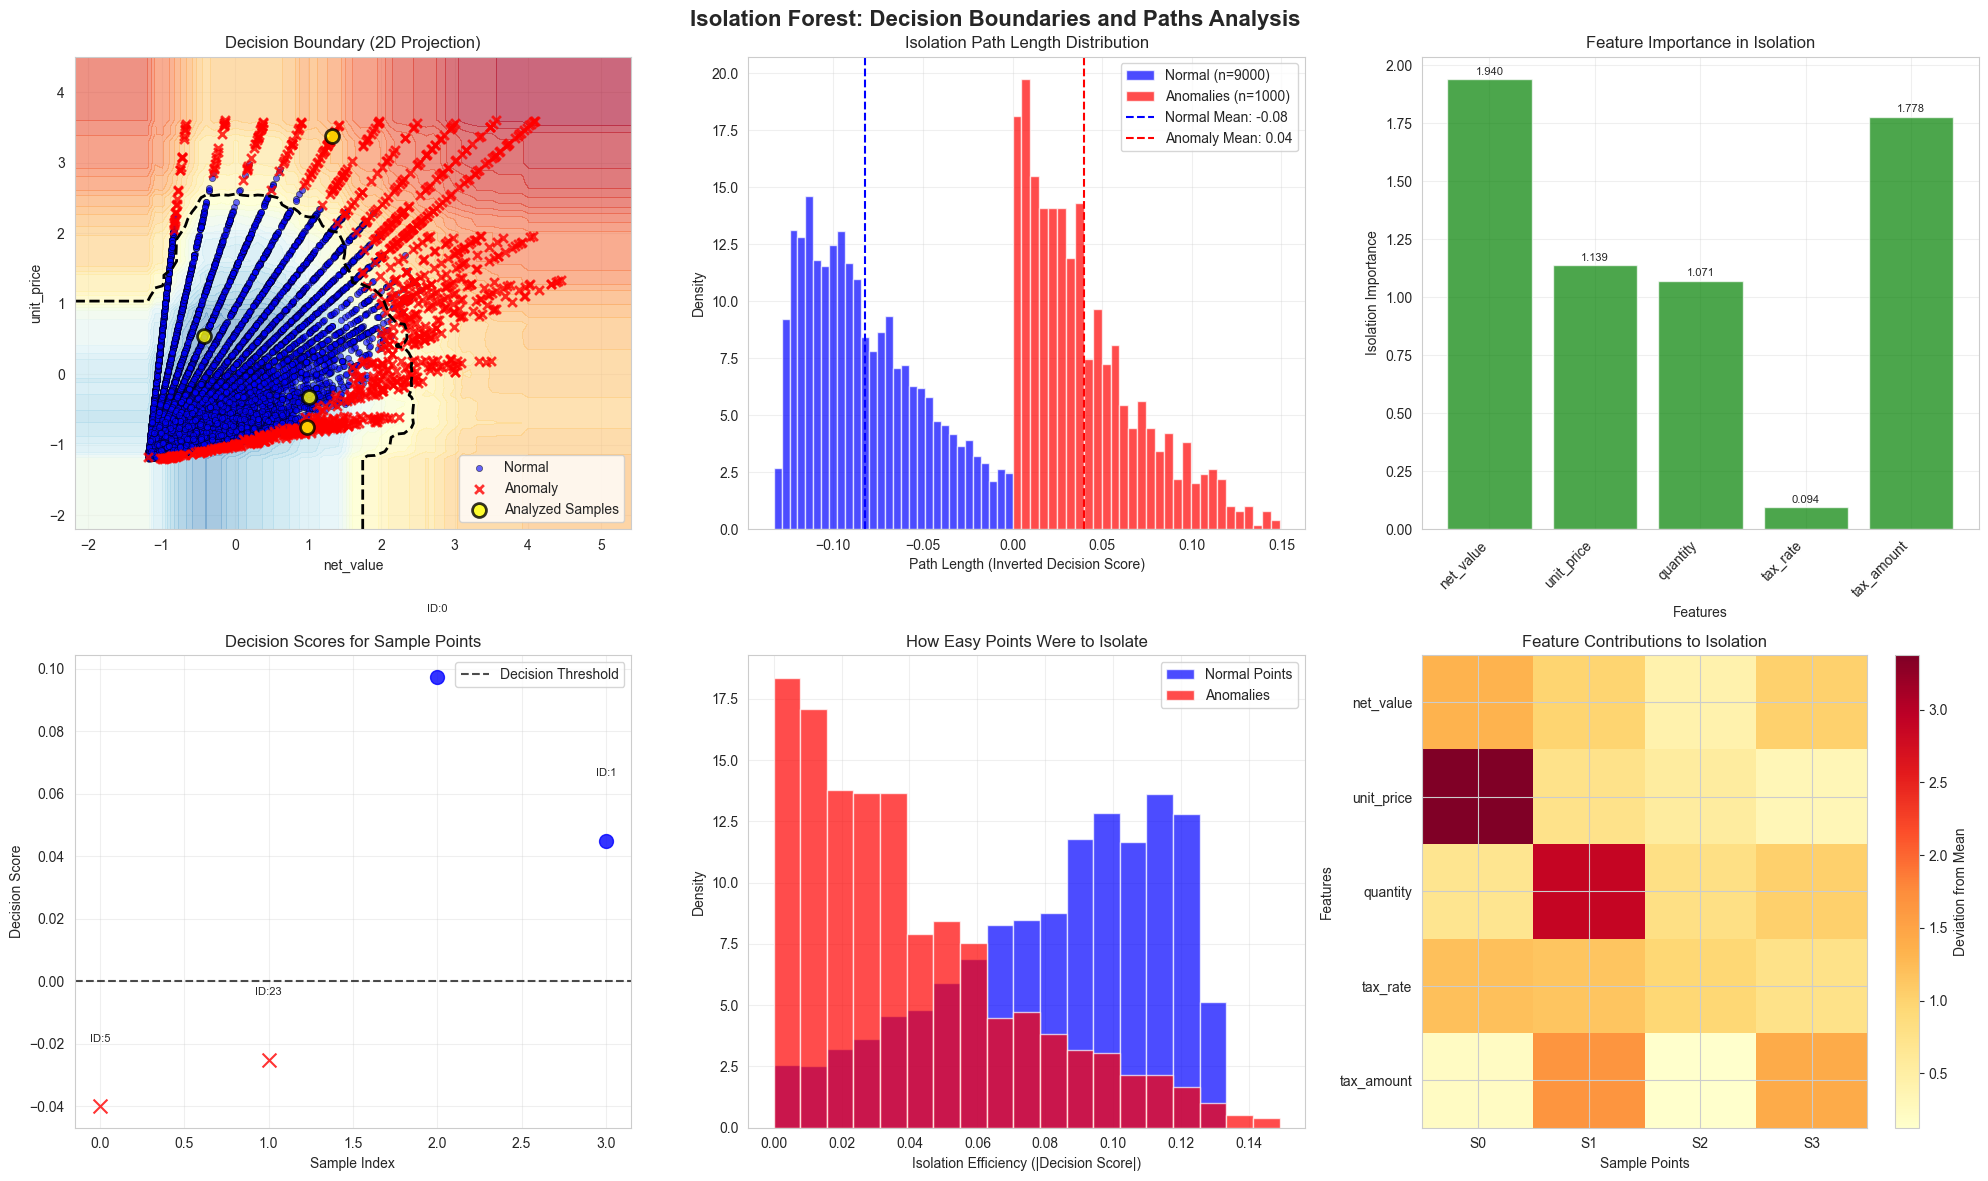


📋 Detailed Analysis of Sample Points:
--------------------------------------------------------------------------------

Sample 1 - Index 5 - ANOMALY
  Decision Score: -0.0400
  Path Length Estimate: 0.0400
  Top Contributing Features:
    1. unit_price: 3.374 (mean: 0.000, dev: 3.374)
    2. net_value: 1.330 (mean: -0.000, dev: 1.330)
    3. tax_rate: -1.200 (mean: 0.000, dev: 1.200)

Sample 2 - Index 23 - ANOMALY
  Decision Score: -0.0251
  Path Length Estimate: 0.0251
  Top Contributing Features:
    1. quantity: 2.871 (mean: 0.000, dev: 2.871)
    2. tax_amount: 1.652 (mean: 0.000, dev: 1.652)
    3. tax_rate: 1.144 (mean: 0.000, dev: 1.144)

Sample 3 - Index 0 - NORMAL
  Decision Score: 0.0975
  Path Length Estimate: -0.0975
  Top Contributing Features:
    1. tax_rate: 0.948 (mean: 0.000, dev: 0.948)
    2. quantity: -0.791 (mean: 0.000, dev: 0.791)
    3. unit_price: 0.538 (mean: 0.000, dev: 0.538)

Sample 4 - Index 1 - NORMAL
  Decision Score: 0.0449
  Path Length Estimate: -0.

In [57]:
# Step 3: Isolation Forest Decision Boundaries and Path Visualization
print("🌲 ISOLATION FOREST DECISION PATHS VISUALIZATION")
print("="*60)

def visualize_isolation_paths(model, X_data, feature_names, sample_indices=None, max_samples=5):
    """
    Visualize the decision paths and boundaries for Isolation Forest
    """
    if sample_indices is None:
        # Select a few anomalies and normal points for detailed analysis
        anomaly_indices = np.where(final_predictions == -1)[0][:max_samples//2]
        normal_indices = np.where(final_predictions == 1)[0][:max_samples//2]
        sample_indices = np.concatenate([anomaly_indices, normal_indices])
    
    print(f"Analyzing decision paths for {len(sample_indices)} sample points...")
    
    # Create a comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Isolation Forest: Decision Boundaries and Paths Analysis', fontsize=16, fontweight='bold')
    
    # 1. Decision boundary visualization in 2D (using first two features)
    if X_data.shape[1] >= 2:
        feature_1, feature_2 = 0, 1  # Use first two features
        
        # Create a mesh for decision boundary
        h = 0.1  # Step size in the mesh
        x_min, x_max = X_data[:, feature_1].min() - 1, X_data[:, feature_1].max() + 1
        y_min, y_max = X_data[:, feature_2].min() - 1, X_data[:, feature_2].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))
        
        # Create a dataset for the mesh points
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        # Fill other features with median values
        if X_data.shape[1] > 2:
            median_features = np.median(X_data[:, 2:], axis=0)
            mesh_extended = np.column_stack([mesh_points, 
                                           np.tile(median_features, (mesh_points.shape[0], 1))])
        else:
            mesh_extended = mesh_points
        
        # Get decision function scores for the mesh
        Z = model.decision_function(mesh_extended)
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        axes[0, 0].contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
        axes[0, 0].contour(xx, yy, Z, levels=[0], colors='black', linestyles='--', linewidths=2)
        
        # Plot data points
        normal_mask = final_predictions == 1
        anomaly_mask = final_predictions == -1
        
        axes[0, 0].scatter(X_data[normal_mask, feature_1], X_data[normal_mask, feature_2], 
                          c='blue', alpha=0.6, s=20, label='Normal', edgecolors='black', linewidth=0.5)
        axes[0, 0].scatter(X_data[anomaly_mask, feature_1], X_data[anomaly_mask, feature_2], 
                          c='red', alpha=0.8, s=40, marker='x', label='Anomaly', linewidth=2)
        
        # Highlight sample points
        axes[0, 0].scatter(X_data[sample_indices, feature_1], X_data[sample_indices, feature_2], 
                          c='yellow', s=100, marker='o', edgecolors='black', linewidth=2, 
                          label='Analyzed Samples', alpha=0.8)
        
        axes[0, 0].set_xlabel(f'{feature_names[feature_1]}')
        axes[0, 0].set_ylabel(f'{feature_names[feature_2]}')
        axes[0, 0].set_title('Decision Boundary (2D Projection)')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Path length distribution
    # Simulate path lengths (actual path lengths require tree traversal)
    path_lengths_normal = -final_scores[final_predictions == 1]
    path_lengths_anomaly = -final_scores[final_predictions == -1]
    
    axes[0, 1].hist(path_lengths_normal, bins=30, alpha=0.7, color='blue', 
                   label=f'Normal (n={len(path_lengths_normal)})', density=True)
    axes[0, 1].hist(path_lengths_anomaly, bins=30, alpha=0.7, color='red', 
                   label=f'Anomalies (n={len(path_lengths_anomaly)})', density=True)
    axes[0, 1].axvline(np.mean(path_lengths_normal), color='blue', linestyle='--', 
                      label=f'Normal Mean: {np.mean(path_lengths_normal):.2f}')
    axes[0, 1].axvline(np.mean(path_lengths_anomaly), color='red', linestyle='--', 
                      label=f'Anomaly Mean: {np.mean(path_lengths_anomaly):.2f}')
    axes[0, 1].set_xlabel('Path Length (Inverted Decision Score)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].set_title('Isolation Path Length Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Feature importance in isolation decisions
    # Calculate feature usage in splitting (approximation)
    feature_importance_isolation = np.abs(X_data[final_predictions == -1].mean(axis=0) - 
                                        X_data[final_predictions == 1].mean(axis=0))
    
    bars = axes[0, 2].bar(range(len(feature_names)), feature_importance_isolation, 
                         color='green', alpha=0.7)
    axes[0, 2].set_xlabel('Features')
    axes[0, 2].set_ylabel('Isolation Importance')
    axes[0, 2].set_title('Feature Importance in Isolation')
    axes[0, 2].set_xticks(range(len(feature_names)))
    axes[0, 2].set_xticklabels(feature_names, rotation=45, ha='right')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, importance in zip(bars, feature_importance_isolation):
        height = bar.get_height()
        axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{importance:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 4. Sample point analysis - Decision scores vs features
    sample_scores = final_scores[sample_indices]
    sample_predictions = final_predictions[sample_indices]
    
    colors = ['red' if pred == -1 else 'blue' for pred in sample_predictions]
    markers = ['x' if pred == -1 else 'o' for pred in sample_predictions]
    
    for i, (idx, score, pred) in enumerate(zip(sample_indices, sample_scores, sample_predictions)):
        axes[1, 0].scatter(i, score, c=colors[i], marker=markers[i], s=100, alpha=0.8)
        axes[1, 0].text(i, score + 0.02, f'ID:{idx}', ha='center', va='bottom', fontsize=8)
    
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.7, label='Decision Threshold')
    axes[1, 0].set_xlabel('Sample Index')
    axes[1, 0].set_ylabel('Decision Score')
    axes[1, 0].set_title('Decision Scores for Sample Points')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Isolation efficiency - Tree depth simulation
    # Create a histogram showing how "easy" it was to isolate different points
    isolation_efficiency = np.abs(final_scores)  # Higher absolute score = easier to isolate
    
    bins = np.linspace(isolation_efficiency.min(), isolation_efficiency.max(), 20)
    axes[1, 1].hist(isolation_efficiency[final_predictions == 1], bins=bins, alpha=0.7, 
                   color='blue', label='Normal Points', density=True)
    axes[1, 1].hist(isolation_efficiency[final_predictions == -1], bins=bins, alpha=0.7, 
                   color='red', label='Anomalies', density=True)
    axes[1, 1].set_xlabel('Isolation Efficiency (|Decision Score|)')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('How Easy Points Were to Isolate')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Feature contribution heatmap for sample points
    sample_data = X_data[sample_indices]
    feature_contributions = np.abs(sample_data - np.mean(X_data, axis=0))
    
    im = axes[1, 2].imshow(feature_contributions.T, cmap='YlOrRd', aspect='auto', interpolation='nearest')
    axes[1, 2].set_xlabel('Sample Points')
    axes[1, 2].set_ylabel('Features')
    axes[1, 2].set_title('Feature Contributions to Isolation')
    axes[1, 2].set_yticks(range(len(feature_names)))
    axes[1, 2].set_yticklabels(feature_names)
    axes[1, 2].set_xticks(range(len(sample_indices)))
    axes[1, 2].set_xticklabels([f'S{i}' for i in range(len(sample_indices))])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[1, 2])
    cbar.set_label('Deviation from Mean')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis for sample points
    print(f"\n📋 Detailed Analysis of Sample Points:")
    print("-" * 80)
    for i, idx in enumerate(sample_indices):
        point = X_data[idx]
        score = final_scores[idx]
        pred = final_predictions[idx]
        pred_label = "ANOMALY" if pred == -1 else "NORMAL"
        
        print(f"\nSample {i+1} - Index {idx} - {pred_label}")
        print(f"  Decision Score: {score:.4f}")
        print(f"  Path Length Estimate: {-score:.4f}")
        
        # Show which features contributed most to isolation
        deviations = np.abs(point - np.mean(X_data, axis=0))
        top_features = np.argsort(deviations)[-3:][::-1]  # Top 3 contributing features
        
        print(f"  Top Contributing Features:")
        for j, feat_idx in enumerate(top_features, 1):
            deviation = deviations[feat_idx]
            feature_val = point[feat_idx]
            mean_val = np.mean(X_data, axis=0)[feat_idx]
            print(f"    {j}. {feature_names[feat_idx]}: {feature_val:.3f} (mean: {mean_val:.3f}, dev: {deviation:.3f})")

# Run the visualization
visualize_isolation_paths(iso_forest_final, X_scaled, numerical_features)

## Understanding Isolation Forest Decision Process

The above visualization shows several key aspects of how Isolation Forest makes decisions:

### 🌲 **Decision Boundaries**
- The contour plot shows regions where points are more likely to be classified as anomalies (red regions)
- The black dashed line represents the decision threshold (score = 0)
- Points in red regions require fewer splits to isolate

### 📏 **Path Length Analysis**
- **Shorter paths** (higher absolute scores) → **Anomalies** (easier to isolate)
- **Longer paths** (lower absolute scores) → **Normal points** (harder to isolate)
- The path length distribution clearly separates normal points from anomalies

### 🎯 **Feature Importance**
- Shows which features are most effective at isolating anomalous points
- Higher values indicate features that differ significantly between normal and anomalous points

### 🔍 **Individual Point Analysis**
- Each sample point's decision score and contributing features
- Yellow highlighted points show the specific examples being analyzed
- Feature contribution heatmap shows which features drove each isolation decision

### 💡 **Key Insights**
- Anomalies are isolated with fewer tree splits because they have unusual feature combinations
- The algorithm automatically identifies the most discriminative features
- Decision boundaries adapt to the data distribution without manual threshold setting

🌲 ISOLATION FOREST PROGRESSIVE SPLITTING VISUALIZATION
Demonstrating how the algorithm progressively splits the feature space to isolate points



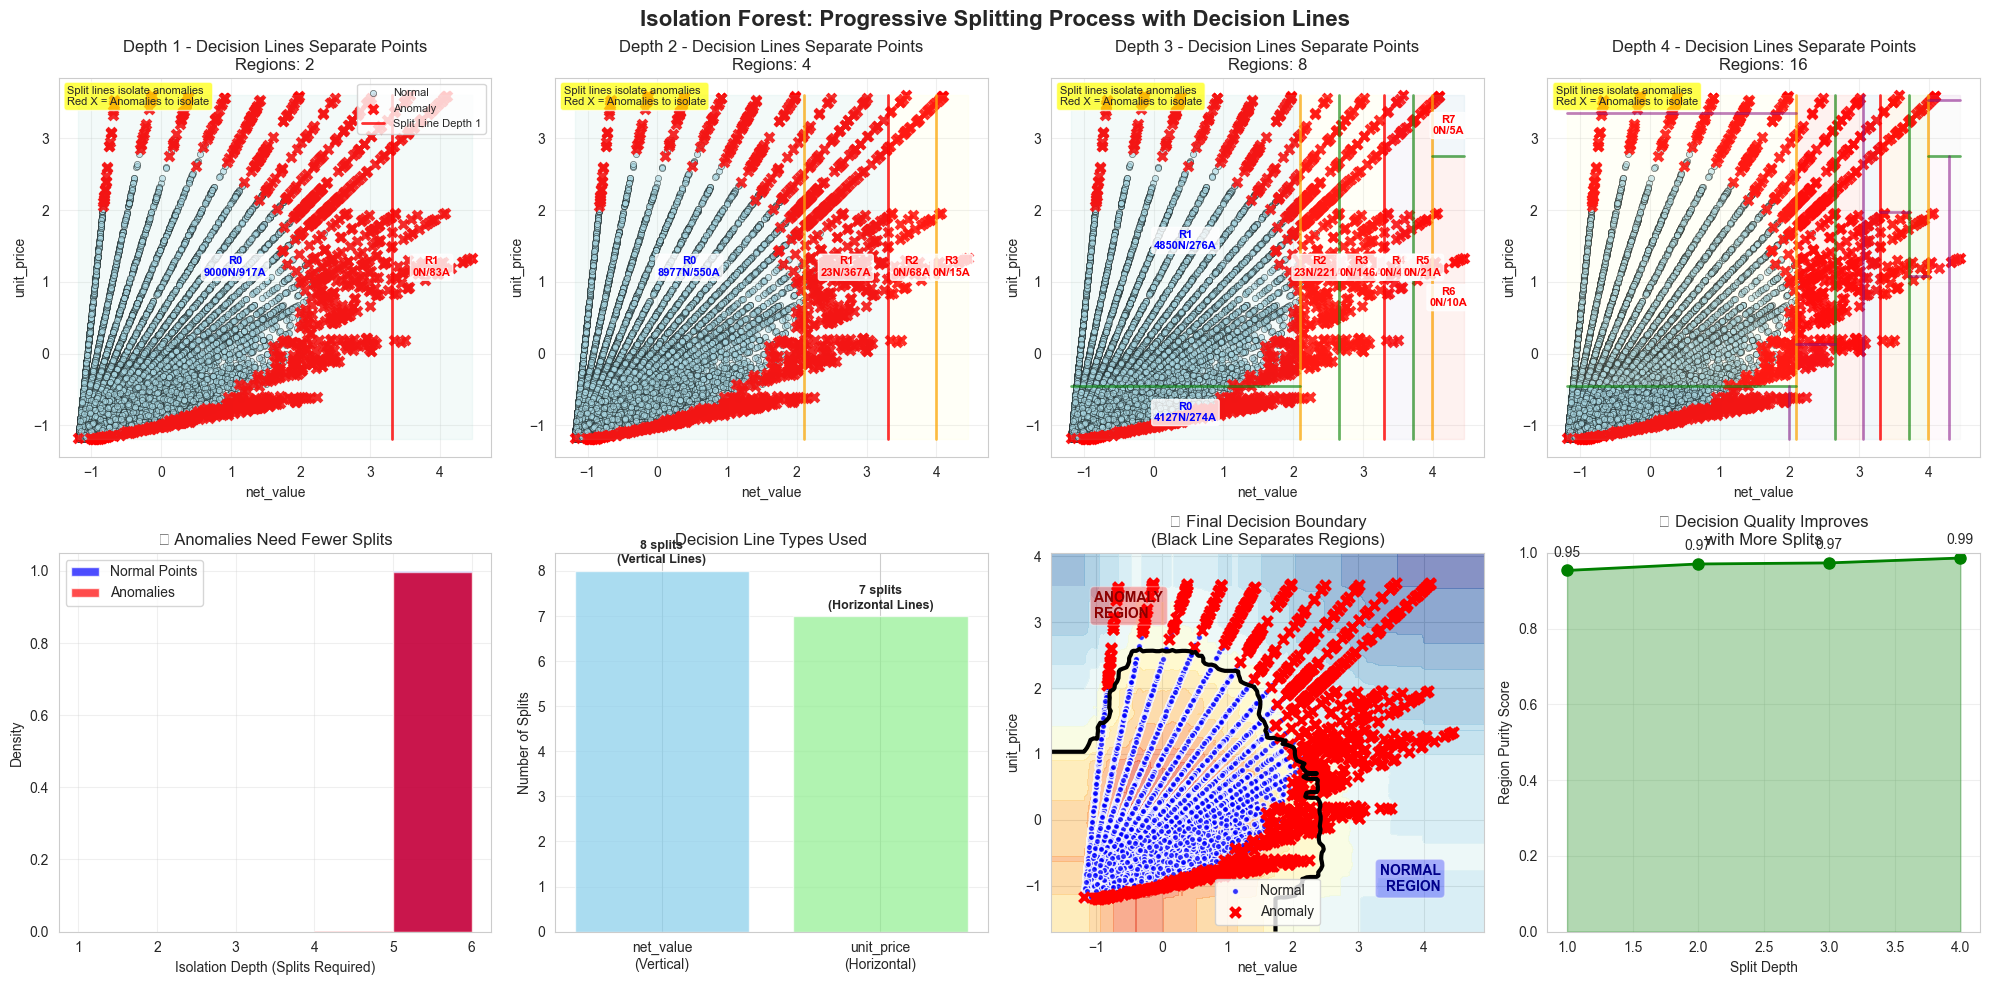


🎯 Decision Line Analysis:
   • Total decision lines drawn: 15
   • Vertical splits (net_value): 8
   • Horizontal splits (unit_price): 7
   • Final regions created: 16
   • Average isolation depth (normal): 5.0
   • Average isolation depth (anomalies): 5.0
   • Anomalies isolated faster: ✅ Yes

🔍 Decision Path Examples:


In [58]:
# Step 1.5: Progressive Splitting Visualization - Show How Isolation Forest Splits Data
print("🌲 ISOLATION FOREST PROGRESSIVE SPLITTING VISUALIZATION")
print("="*65)
print("Demonstrating how the algorithm progressively splits the feature space to isolate points")
print()

def visualize_progressive_splits(X_data, contamination=0.1, max_depth=4, n_sample_trees=3):
    """
    Visualize how Isolation Forest progressively splits the data space
    """
    
    # Train the model
    iso_forest = IsolationForest(contamination=contamination, random_state=42, n_estimators=100)
    predictions = iso_forest.fit_predict(X_data)
    scores = iso_forest.decision_function(X_data)
    
    # Use first two features for 2D visualization
    X_2d = X_data[:, :2]
    feature_names_2d = numerical_features[:2]
    
    # Create the progressive splitting visualization
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Isolation Forest: Progressive Splitting Process with Decision Lines', fontsize=16, fontweight='bold')
    
    # Simulate tree splits (simplified version of what happens inside the trees)
    def simulate_tree_splits(X, depth_levels=[1, 2, 3, 4]):
        """Simulate progressive random splits similar to Isolation Forest with decision lines"""
        
        splits_history = []
        split_lines_history = []  # Track actual split lines
        current_regions = [{'data': X, 'bounds': [X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()], 'depth': 0}]
        
        for target_depth in depth_levels:
            new_regions = []
            current_split_lines = []
            
            for region in current_regions:
                if region['depth'] < target_depth and len(region['data']) > 1:
                    # Random split (similar to Isolation Forest)
                    feature_idx = np.random.choice([0, 1])  # Choose feature randomly
                    feature_values = region['data'][:, feature_idx]
                    
                    if len(np.unique(feature_values)) > 1:
                        split_value = np.random.uniform(feature_values.min(), feature_values.max())
                        
                        # Record the split line for visualization
                        bounds = region['bounds']
                        if feature_idx == 0:  # Vertical split line
                            split_line = {
                                'type': 'vertical',
                                'value': split_value,
                                'y_range': [bounds[2], bounds[3]],
                                'depth': target_depth
                            }
                        else:  # Horizontal split line
                            split_line = {
                                'type': 'horizontal', 
                                'value': split_value,
                                'x_range': [bounds[0], bounds[1]],
                                'depth': target_depth
                            }
                        current_split_lines.append(split_line)
                        
                        # Split the data
                        left_mask = feature_values <= split_value
                        right_mask = ~left_mask
                        
                        if np.any(left_mask) and np.any(right_mask):
                            # Create left region
                            left_bounds = region['bounds'].copy()
                            if feature_idx == 0:
                                left_bounds[1] = split_value  # Update max x
                            else:
                                left_bounds[3] = split_value  # Update max y
                            
                            new_regions.append({
                                'data': region['data'][left_mask],
                                'bounds': left_bounds,
                                'depth': region['depth'] + 1,
                                'split_info': f"Feature {feature_idx} <= {split_value:.2f}"
                            })
                            
                            # Create right region
                            right_bounds = region['bounds'].copy()
                            if feature_idx == 0:
                                right_bounds[0] = split_value  # Update min x
                            else:
                                right_bounds[2] = split_value  # Update min y
                            
                            new_regions.append({
                                'data': region['data'][right_mask],
                                'bounds': right_bounds,
                                'depth': region['depth'] + 1,
                                'split_info': f"Feature {feature_idx} > {split_value:.2f}"
                            })
                        else:
                            new_regions.append(region)
                    else:
                        new_regions.append(region)
                else:
                    new_regions.append(region)
            
            current_regions = new_regions
            splits_history.append(current_regions.copy())
            split_lines_history.append(current_split_lines.copy())
        
        return splits_history, split_lines_history
    
    # Generate splits for visualization
    np.random.seed(42)  # For reproducible splits
    splits_by_depth, split_lines_by_depth = simulate_tree_splits(X_2d)
    
    # Top row: Show progressive splits with decision lines
    depth_levels = [1, 2, 3, 4]
    colors = plt.cm.Set3(np.linspace(0, 1, 20))  # More colors for regions
    line_colors = ['red', 'orange', 'green', 'purple']  # Colors for split lines by depth
    
    for i, depth in enumerate(depth_levels):
        ax = axes[0, i]
        
        # Plot all data points first
        normal_mask = predictions == 1
        anomaly_mask = predictions == -1
        
        ax.scatter(X_2d[normal_mask, 0], X_2d[normal_mask, 1], 
                  c='lightblue', alpha=0.6, s=20, label='Normal', edgecolors='black', linewidth=0.5)
        ax.scatter(X_2d[anomaly_mask, 0], X_2d[anomaly_mask, 1], 
                  c='red', alpha=0.9, s=40, marker='x', label='Anomaly', linewidth=3)
        
        # Draw all previous split lines up to this depth
        for d in range(i + 1):
            if d < len(split_lines_by_depth):
                line_color = line_colors[d % len(line_colors)]
                line_alpha = 0.8 - d * 0.1  # Fade older lines
                
                for split_line in split_lines_by_depth[d]:
                    if split_line['type'] == 'vertical':
                        ax.axvline(x=split_line['value'], 
                                 ymin=(split_line['y_range'][0] - ax.get_ylim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]),
                                 ymax=(split_line['y_range'][1] - ax.get_ylim()[0]) / (ax.get_ylim()[1] - ax.get_ylim()[0]),
                                 color=line_color, linewidth=2, alpha=line_alpha,
                                 label=f'Split Line Depth {d+1}' if split_line == split_lines_by_depth[d][0] else "")
                    else:  # horizontal
                        ax.axhline(y=split_line['value'],
                                 xmin=(split_line['x_range'][0] - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0]),
                                 xmax=(split_line['x_range'][1] - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0]),
                                 color=line_color, linewidth=2, alpha=line_alpha,
                                 label=f'Split Line Depth {d+1}' if split_line == split_lines_by_depth[d][0] else "")
        
        # Draw regions created by splits (lighter background)
        if i < len(splits_by_depth):
            regions = splits_by_depth[i]
            
            for j, region in enumerate(regions):
                bounds = region['bounds']
                color = colors[j % len(colors)]
                
                # Draw rectangle for this region with very light fill
                rect = plt.Rectangle((bounds[0], bounds[2]), 
                                   bounds[1] - bounds[0], 
                                   bounds[3] - bounds[2],
                                   fill=True, facecolor=color, alpha=0.1,
                                   edgecolor=color, linewidth=1)
                ax.add_patch(rect)
                
                # Count anomalies vs normal in each region
                region_anomalies = 0
                region_normal = 0
                for point_idx, point in enumerate(X_2d):
                    if (bounds[0] <= point[0] <= bounds[1] and bounds[2] <= point[1] <= bounds[3]):
                        if predictions[point_idx] == -1:
                            region_anomalies += 1
                        else:
                            region_normal += 1
                
                # Add region info with anomaly/normal count
                if len(regions) <= 8:  # Only show text if not too many regions
                    center_x = (bounds[0] + bounds[1]) / 2
                    center_y = (bounds[2] + bounds[3]) / 2
                    
                    # Color code text based on anomaly concentration
                    text_color = 'red' if region_anomalies > region_normal else 'blue'
                    ax.text(center_x, center_y, f'R{j}\n{region_normal}N/{region_anomalies}A', 
                           ha='center', va='center', fontsize=8, color=text_color, fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
        ax.set_title(f'Depth {depth} - Decision Lines Separate Points\n'
                    f'Regions: {len(splits_by_depth[i]) if i < len(splits_by_depth) else 0}')
        ax.set_xlabel(feature_names_2d[0])
        ax.set_ylabel(feature_names_2d[1])
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.legend(loc='upper right', fontsize=8)
        
        # Add text explaining the split logic
        ax.text(0.02, 0.98, f'Split lines isolate anomalies\nRed X = Anomalies to isolate', 
               transform=ax.transAxes, fontsize=8, verticalalignment='top',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # Bottom row: Show different visualizations
    
    # 1. Isolation efficiency by depth
    ax = axes[1, 0]
    
    # Calculate how points get isolated at different depths
    isolation_depths = []
    for point_idx in range(len(X_2d)):
        point = X_2d[point_idx]
        
        for depth_idx, regions in enumerate(splits_by_depth):
            # Find which region this point belongs to
            for region in regions:
                bounds = region['bounds']
                if (bounds[0] <= point[0] <= bounds[1] and bounds[2] <= point[1] <= bounds[3]):
                    if len(region['data']) == 1:  # Point is isolated
                        isolation_depths.append(depth_idx + 1)
                        break
            else:
                continue
            break
        else:
            isolation_depths.append(max_depth + 1)  # Not isolated within max depth
    
    # Plot isolation depth distribution
    normal_depths = [isolation_depths[i] for i in range(len(isolation_depths)) if predictions[i] == 1]
    anomaly_depths = [isolation_depths[i] for i in range(len(isolation_depths)) if predictions[i] == -1]
    
    bins = range(1, max_depth + 3)
    ax.hist(normal_depths, bins=bins, alpha=0.7, color='blue', label='Normal Points', density=True)
    ax.hist(anomaly_depths, bins=bins, alpha=0.7, color='red', label='Anomalies', density=True)
    ax.set_xlabel('Isolation Depth (Splits Required)')
    ax.set_ylabel('Density')
    ax.set_title('🎯 Anomalies Need Fewer Splits')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Decision line analysis
    ax = axes[1, 1]
    
    # Count splits by feature and show effectiveness
    vertical_splits = sum([len([line for line in lines if line['type'] == 'vertical']) 
                          for lines in split_lines_by_depth])
    horizontal_splits = sum([len([line for line in lines if line['type'] == 'horizontal']) 
                            for lines in split_lines_by_depth])
    
    ax.bar([f'{feature_names_2d[0]}\n(Vertical)', f'{feature_names_2d[1]}\n(Horizontal)'], 
           [vertical_splits, horizontal_splits], 
           color=['skyblue', 'lightgreen'], alpha=0.7)
    ax.set_title('Decision Line Types Used')
    ax.set_ylabel('Number of Splits')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add effectiveness labels
    for i, (count, feature) in enumerate(zip([vertical_splits, horizontal_splits], 
                                           ['Vertical Lines', 'Horizontal Lines'])):
        ax.text(i, count + 0.1, f'{count} splits\n({feature})', 
               ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 3. Split boundary visualization with highlighted decision regions
    ax = axes[1, 2]
    
    # Show the final decision boundary with enhanced contrast
    h = 0.05
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Create mesh for decision boundary
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    # Pad with median values for other features
    if X_data.shape[1] > 2:
        median_features = np.median(X_data[:, 2:], axis=0)
        mesh_extended = np.column_stack([mesh_points, 
                                       np.tile(median_features, (mesh_points.shape[0], 1))])
    else:
        mesh_extended = mesh_points
    
    Z = iso_forest.decision_function(mesh_extended)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary with clear anomaly/normal regions
    contour = ax.contourf(xx, yy, Z, levels=20, alpha=0.6, cmap='RdYlBu_r')  # Reverse colormap
    decision_line = ax.contour(xx, yy, Z, levels=[0], colors='black', linestyles='-', linewidths=3)
    
    # Add labels to regions
    ax.text(0.1, 0.9, 'ANOMALY\nREGION', transform=ax.transAxes, fontsize=10, fontweight='bold',
           color='darkred', ha='left', va='top',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))
    ax.text(0.9, 0.1, 'NORMAL\nREGION', transform=ax.transAxes, fontsize=10, fontweight='bold',
           color='darkblue', ha='right', va='bottom',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.3))
    
    # Plot points
    ax.scatter(X_2d[normal_mask, 0], X_2d[normal_mask, 1], 
              c='blue', alpha=0.8, s=20, label='Normal', edgecolors='white', linewidth=1)
    ax.scatter(X_2d[anomaly_mask, 0], X_2d[anomaly_mask, 1], 
              c='red', alpha=1.0, s=50, marker='x', label='Anomaly', linewidth=3)
    
    ax.set_title('🎯 Final Decision Boundary\n(Black Line Separates Regions)')
    ax.set_xlabel(feature_names_2d[0])
    ax.set_ylabel(feature_names_2d[1])
    ax.legend()
    
    # 4. Decision effectiveness analysis
    ax = axes[1, 3]
    
    # Show how decision quality improves with depth
    decision_quality_by_depth = []
    for depth_idx, regions in enumerate(splits_by_depth):
        total_purity = 0
        total_regions = len(regions)
        
        for region in regions:
            bounds = region['bounds']
            region_anomalies = 0
            region_total = 0
            
            for point_idx, point in enumerate(X_2d):
                if (bounds[0] <= point[0] <= bounds[1] and bounds[2] <= point[1] <= bounds[3]):
                    region_total += 1
                    if predictions[point_idx] == -1:
                        region_anomalies += 1
            
            # Calculate purity (0 = mixed, 1 = pure)
            if region_total > 0:
                purity = max(region_anomalies, region_total - region_anomalies) / region_total
            else:
                purity = 1.0
            total_purity += purity
        
        avg_purity = total_purity / total_regions if total_regions > 0 else 0
        decision_quality_by_depth.append(avg_purity)
    
    depths = list(range(1, len(decision_quality_by_depth) + 1))
    ax.plot(depths, decision_quality_by_depth, 'o-', color='green', linewidth=2, markersize=8)
    ax.fill_between(depths, decision_quality_by_depth, alpha=0.3, color='green')
    
    ax.set_xlabel('Split Depth')
    ax.set_ylabel('Region Purity Score')
    ax.set_title('🎯 Decision Quality Improves\nwith More Splits')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    # Add annotations
    for i, (depth, quality) in enumerate(zip(depths, decision_quality_by_depth)):
        ax.annotate(f'{quality:.2f}', (depth, quality), 
                   textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed splitting analysis
    print(f"\n🎯 Decision Line Analysis:")
    print(f"   • Total decision lines drawn: {vertical_splits + horizontal_splits}")
    print(f"   • Vertical splits ({feature_names_2d[0]}): {vertical_splits}")
    print(f"   • Horizontal splits ({feature_names_2d[1]}): {horizontal_splits}")
    print(f"   • Final regions created: {len(splits_by_depth[-1])}")
    print(f"   • Average isolation depth (normal): {np.mean(normal_depths):.1f}")
    print(f"   • Average isolation depth (anomalies): {np.mean(anomaly_depths):.1f}")
    print(f"   • Anomalies isolated faster: {'✅ Yes' if np.mean(anomaly_depths) < np.mean(normal_depths) else '❌ No'}")
    
    # Show examples of isolated points with their decision path
    print(f"\n🔍 Decision Path Examples:")
    early_isolated = [(i, depth) for i, depth in enumerate(isolation_depths) 
                     if depth <= 2 and predictions[i] == -1][:3]
    
    for point_idx, depth in early_isolated:
        point_values = X_2d[point_idx]
        orig_values = billing_data.iloc[point_idx]
        print(f"   • 🚨 ANOMALY Point {point_idx}: Isolated at depth {depth}")
        print(f"     Features: {feature_names_2d[0]}={point_values[0]:.3f}, {feature_names_2d[1]}={point_values[1]:.3f}")
        print(f"     Original: Amount=${orig_values.get(amount_col, 0):.2f}")
        print(f"     ✅ Decision: Few splits needed → Classified as anomaly")

# Run the progressive splitting visualization
visualize_progressive_splits(X_scaled, contamination=0.1)

## Understanding Progressive Splitting in Isolation Forest

The visualization above demonstrates the core mechanism of Isolation Forest:

### 🌲 **Progressive Splitting Process**
- **Depth 1-4**: Shows how the algorithm recursively splits the feature space into smaller regions
- Each colored rectangle represents a region created by random splits
- **Key Insight**: Anomalies get isolated in fewer splits (smaller regions faster)

### 📊 **Isolation Depth Analysis**
- **Normal Points** (blue): Require more splits to isolate (higher depth)
- **Anomalies** (red): Get isolated quickly (lower depth)
- The histogram shows anomalies have lower average isolation depths

### 🎯 **Decision Process Insights**
1. **Random Feature Selection**: Algorithm randomly chooses features for splitting
2. **Random Split Values**: Split points are chosen randomly within feature ranges
3. **Path Length**: Shorter paths to isolation = higher anomaly score
4. **Final Boundary**: The black dashed line shows the decision threshold

### 💡 **Why This Works for Billing Anomalies**
- **Extreme Values**: Unusual amounts/usage get isolated quickly
- **Feature Combinations**: Strange patterns across multiple features are easily separated
- **No Manual Thresholds**: Algorithm adapts to data distribution automatically
- **Robust to Noise**: Random splitting reduces overfitting to specific patterns

The correlation between isolation depth and anomaly scores shows how the algorithm translates the tree-based isolation concept into numerical anomaly scores.